In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_effnetb0_2'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds/"

    # ============== model cfg =============
    model_name = "tf_efficientnet_b0_ns"

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 40
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-3
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),

        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月23日 15:43:41


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import torch.nn.functional as F

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [17]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        self.n_features = self.model.num_features

        self.target_size = cfg.target_size if target_size is None else target_size
        self.pooling = GeM()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(self.n_features, self.target_size)

        # # nn.Dropout(0.5),
        # self.fc = nn.Sequential(
        #     nn.Linear(self.n_features, self.target_size)
        # )

    def forward(self, image):
        # 特徴量抽出
        features = self.model(image)  # [batch_size, channels, height, width]
        
        # 入力が4次元でない場合は4次元に変換
        if features.dim() != 4:
            features = features.unsqueeze(-1).unsqueeze(-1)
        
        # GeM プーリング (4D入力を想定)
        pooled_features = self.pooling(features)  # [batch_size, channels, 1, 1]
        
        # 平坦化
        pooled_features = pooled_features.view(pooled_features.size(0), -1)  # [batch_size, channels]
        
        # ドロップアウトと全結合層
        pooled_features = self.dropout(pooled_features)
        output = self.linear(pooled_features)
        return output

# scheduler

In [18]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [19]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [20]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [21]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for df_score in list_df_score:
        ax1.plot(df_score['val_loss'])
        ax2.plot(df_score['val_score'])
    ax1.set_title('Validation Loss')
    ax2.set_title('Validation Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Score')
    ax1.set_ylim([0, 1.5])
    ax2.set_ylim([0, 1.5])
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========
/workspace/atmacup18/.venv/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


pretrained: True


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 20m 47s) Loss: 4.6440(4.6440) Grad: 36808.4414  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.4431(2.6139) Grad: 50074.9648  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.3171(2.5218) Grad: 50151.9766  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 55s) Loss: 1.6953(1.6953) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.5218  avg_val_loss: 1.9804  time: 65s
Epoch 1 - avg_train_Score: 2.5218 avgScore: 1.9804
Epoch 1 - Save Best Score: 1.9804 Model
Epoch 1 - Save Best Loss: 1.9804 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8032(1.9804) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 1.1678(1.1678) Grad: 175606.4688  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.2258(1.2180) Grad: 204455.8906  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1074(1.2181) Grad: 286562.8125  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 1.0278(1.0278) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.2181  avg_val_loss: 1.1286  time: 64s
Epoch 2 - avg_train_Score: 1.2181 avgScore: 1.1286


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1026(1.1286) 


Epoch 2 - Save Best Score: 1.1286 Model
Epoch 2 - Save Best Loss: 1.1286 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 1.1131(1.1131) Grad: 227516.2656  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.3454(1.2622) Grad: 77600.2109  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.3570(1.2624) Grad: 61474.7383  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 1.0146(1.0146) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2624  avg_val_loss: 1.0402  time: 64s
Epoch 3 - avg_train_Score: 1.2624 avgScore: 1.0402
Epoch 3 - Save Best Score: 1.0402 Model
Epoch 3 - Save Best Loss: 1.0402 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0566(1.0402) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 1.0287(1.0287) Grad: 149230.7969  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9019(1.0442) Grad: 100882.2422  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9857(1.0411) Grad: 132991.1406  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8814(0.8814) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0411  avg_val_loss: 0.9051  time: 63s
Epoch 4 - avg_train_Score: 1.0411 avgScore: 0.9051
Epoch 4 - Save Best Score: 0.9051 Model
Epoch 4 - Save Best Loss: 0.9051 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8810(0.9051) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 43s) Loss: 0.8973(0.8973) Grad: 114373.8984  LR: 0.000989  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9500(0.9478) Grad: 59806.6328  LR: 0.000989  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8534(0.9517) Grad: 51541.8086  LR: 0.000989  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.8992(0.8992) 
EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8938(0.8768) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9517  avg_val_loss: 0.8768  time: 64s
Epoch 5 - avg_train_Score: 0.9517 avgScore: 0.8768
Epoch 5 - Save Best Score: 0.8768 Model
Epoch 5 - Save Best Loss: 0.8768 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385

Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 1.0000(1.0000) Grad: 105455.8203  LR: 0.000979  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8567(0.9195) Grad: 42370.6250  LR: 0.000979  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8212(0.9191) Grad: 44358.0469  LR: 0.000979  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8003(0.8003) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.9191  avg_val_loss: 0.8299  time: 64s
Epoch 6 - avg_train_Score: 0.9191 avgScore: 0.8299
Epoch 6 - Save Best Score: 0.8299 Model
Epoch 6 - Save Best Loss: 0.8299 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8115(0.8299) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 11s) Loss: 0.5960(0.5960) Grad: 81369.9531  LR: 0.000965  
Epoch: [7][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.7711(0.7488) Grad: 105568.1562  LR: 0.000965  
Epoch: [7][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5198(0.7500) Grad: 89017.3828  LR: 0.000965  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7607(0.7607) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7500  avg_val_loss: 0.7870  time: 63s
Epoch 7 - avg_train_Score: 0.7500 avgScore: 0.7870
Epoch 7 - Save Best Score: 0.7870 Model
Epoch 7 - Save Best Loss: 0.7870 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7842(0.7870) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 54s) Loss: 0.7746(0.7746) Grad: 85745.6406  LR: 0.000949  
Epoch: [8][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.6663(0.6870) Grad: 87906.3281  LR: 0.000949  
Epoch: [8][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.7735(0.6904) Grad: 119526.2344  LR: 0.000949  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7306(0.7306) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7773(0.7768) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6904  avg_val_loss: 0.7768  time: 65s
Epoch 8 - avg_train_Score: 0.6904 avgScore: 0.7768
Epoch 8 - Save Best Score: 0.7768 Model
Epoch 8 - Save Best Loss: 0.7768 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385

Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.7243(0.7243) Grad: 109128.5781  LR: 0.000929  
Epoch: [9][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6568(0.6510) Grad: 119510.2031  LR: 0.000929  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.7381(0.6527) Grad: 83153.4531  LR: 0.000929  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7548(0.7548) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6527  avg_val_loss: 0.7664  time: 64s
Epoch 9 - avg_train_Score: 0.6527 avgScore: 0.7664
Epoch 9 - Save Best Score: 0.7664 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7295(0.7664) 


Epoch 9 - Save Best Loss: 0.7664 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.7465(0.7465) Grad: 124026.6328  LR: 0.000908  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6392(0.6211) Grad: 111800.0781  LR: 0.000908  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5369(0.6217) Grad: 86383.1797  LR: 0.000908  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7387(0.7387) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6217  avg_val_loss: 0.7595  time: 64s
Epoch 10 - avg_train_Score: 0.6217 avgScore: 0.7595
Epoch 10 - Save Best Score: 0.7595 Model
Epoch 10 - Save Best Loss: 0.7595 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7057(0.7595) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.5302(0.5302) Grad: 80515.7422  LR: 0.000883  
Epoch: [11][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5350(0.5955) Grad: 74191.6953  LR: 0.000883  
Epoch: [11][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5908(0.5960) Grad: 90468.4922  LR: 0.000883  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7346(0.7346) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5960  avg_val_loss: 0.7509  time: 65s
Epoch 11 - avg_train_Score: 0.5960 avgScore: 0.7509
Epoch 11 - Save Best Score: 0.7509 Model
Epoch 11 - Save Best Loss: 0.7509 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7289(0.7509) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 16s) Loss: 0.5774(0.5774) Grad: 95589.2422  LR: 0.000857  
Epoch: [12][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.6651(0.5735) Grad: 93225.6797  LR: 0.000857  
Epoch: [12][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.6024(0.5746) Grad: 91200.3750  LR: 0.000857  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7434(0.7434) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7245(0.7447) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5746  avg_val_loss: 0.7447  time: 65s
Epoch 12 - avg_train_Score: 0.5746 avgScore: 0.7447
Epoch 12 - Save Best Score: 0.7447 Model
Epoch 12 - Save Best Loss: 0.7447 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 3s) Loss: 0.5314(0.5314) Grad: 84852.7969  LR: 0.000828  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5132(0.5452) Grad: 80597.9688  LR: 0.000828  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5792(0.5465) Grad: 89625.9766  LR: 0.000828  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7258(0.7258) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5465  avg_val_loss: 0.7384  time: 64s
Epoch 13 - avg_train_Score: 0.5465 avgScore: 0.7384
Epoch 13 - Save Best Score: 0.7384 Model
Epoch 13 - Save Best Loss: 0.7384 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7012(0.7384) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.5288(0.5288) Grad: 88826.8984  LR: 0.000797  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4558(0.5172) Grad: 85117.0938  LR: 0.000797  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5279(0.5193) Grad: 78223.4766  LR: 0.000797  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7387(0.7387) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5193  avg_val_loss: 0.7374  time: 64s
Epoch 14 - avg_train_Score: 0.5193 avgScore: 0.7374
Epoch 14 - Save Best Score: 0.7374 Model
Epoch 14 - Save Best Loss: 0.7374 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6962(0.7374) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.6452(0.6452) Grad: 96460.8125  LR: 0.000764  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4405(0.4962) Grad: 76807.2734  LR: 0.000764  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4845(0.4968) Grad: 94676.7266  LR: 0.000764  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7334(0.7334) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.4968  avg_val_loss: 0.7340  time: 65s
Epoch 15 - avg_train_Score: 0.4968 avgScore: 0.7340
Epoch 15 - Save Best Score: 0.7340 Model
Epoch 15 - Save Best Loss: 0.7340 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6868(0.7340) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 0.5005(0.5005) Grad: 78732.4141  LR: 0.000730  
Epoch: [16][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5897(0.4735) Grad: 81357.7891  LR: 0.000730  
Epoch: [16][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4682(0.4735) Grad: 84494.9141  LR: 0.000730  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7314(0.7314) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4735  avg_val_loss: 0.7315  time: 65s
Epoch 16 - avg_train_Score: 0.4735 avgScore: 0.7315
Epoch 16 - Save Best Score: 0.7315 Model
Epoch 16 - Save Best Loss: 0.7315 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7256(0.7315) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 36s) Loss: 0.4522(0.4522) Grad: 98364.6250  LR: 0.000694  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4371(0.4532) Grad: 90121.7109  LR: 0.000694  
Epoch: [17][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5375(0.4540) Grad: 86904.4297  LR: 0.000694  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7203(0.7203) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7119(0.7309) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4540  avg_val_loss: 0.7309  time: 64s
Epoch 17 - avg_train_Score: 0.4540 avgScore: 0.7309
Epoch 17 - Save Best Score: 0.7309 Model
Epoch 17 - Save Best Loss: 0.7309 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 13s) Loss: 0.5273(0.5273) Grad: 94393.5234  LR: 0.000657  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3788(0.4315) Grad: 66616.3438  LR: 0.000657  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4130(0.4329) Grad: 88995.6797  LR: 0.000657  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7326(0.7326) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4329  avg_val_loss: 0.7300  time: 65s
Epoch 18 - avg_train_Score: 0.4329 avgScore: 0.7300
Epoch 18 - Save Best Score: 0.7300 Model
Epoch 18 - Save Best Loss: 0.7300 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7183(0.7300) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.4490(0.4490) Grad: 72375.6484  LR: 0.000620  
Epoch: [19][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4125(0.4141) Grad: 73464.8281  LR: 0.000620  
Epoch: [19][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3959(0.4141) Grad: 84283.2734  LR: 0.000620  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7042(0.7042) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7235(0.7257) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4141  avg_val_loss: 0.7257  time: 63s
Epoch 19 - avg_train_Score: 0.4141 avgScore: 0.7257
Epoch 19 - Save Best Score: 0.7257 Model
Epoch 19 - Save Best Loss: 0.7257 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.3042(0.3042) Grad: 71378.5156  LR: 0.000581  
Epoch: [20][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3596(0.3993) Grad: 63292.3242  LR: 0.000581  
Epoch: [20][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4135(0.3996) Grad: 77182.3438  LR: 0.000581  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6802(0.6802) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.3996  avg_val_loss: 0.7241  time: 65s
Epoch 20 - avg_train_Score: 0.3996 avgScore: 0.7241
Epoch 20 - Save Best Score: 0.7241 Model
Epoch 20 - Save Best Loss: 0.7241 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7091(0.7241) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.3488(0.3488) Grad: 71413.1016  LR: 0.000542  
Epoch: [21][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3812(0.3823) Grad: 65786.5391  LR: 0.000542  
Epoch: [21][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3359(0.3812) Grad: 66636.2031  LR: 0.000542  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6794(0.6794) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7041(0.7230) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3812  avg_val_loss: 0.7230  time: 64s
Epoch 21 - avg_train_Score: 0.3812 avgScore: 0.7230
Epoch 21 - Save Best Score: 0.7230 Model
Epoch 21 - Save Best Loss: 0.7230 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.3804(0.3804) Grad: 66359.7344  LR: 0.000503  
Epoch: [22][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3747(0.3661) Grad: 68550.9766  LR: 0.000503  
Epoch: [22][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3331(0.3657) Grad: 68286.1016  LR: 0.000503  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6801(0.6801) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3657  avg_val_loss: 0.7219  time: 63s
Epoch 22 - avg_train_Score: 0.3657 avgScore: 0.7219
Epoch 22 - Save Best Score: 0.7219 Model
Epoch 22 - Save Best Loss: 0.7219 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7044(0.7219) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 33s) Loss: 0.3410(0.3410) Grad: 71730.0625  LR: 0.000464  
Epoch: [23][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3457(0.3510) Grad: 67754.3906  LR: 0.000464  
Epoch: [23][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3137(0.3506) Grad: 63338.2500  LR: 0.000464  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6796(0.6796) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3506  avg_val_loss: 0.7193  time: 65s
Epoch 23 - avg_train_Score: 0.3506 avgScore: 0.7193
Epoch 23 - Save Best Score: 0.7193 Model
Epoch 23 - Save Best Loss: 0.7193 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7171(0.7193) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 15s) Loss: 0.3426(0.3426) Grad: 75375.7422  LR: 0.000425  
Epoch: [24][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2927(0.3362) Grad: 61326.9141  LR: 0.000425  
Epoch: [24][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3498(0.3357) Grad: 71010.5234  LR: 0.000425  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6866(0.6866) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3357  avg_val_loss: 0.7167  time: 65s
Epoch 24 - avg_train_Score: 0.3357 avgScore: 0.7167
Epoch 24 - Save Best Score: 0.7167 Model
Epoch 24 - Save Best Loss: 0.7167 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7021(0.7167) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.3616(0.3616) Grad: 63545.4844  LR: 0.000386  
Epoch: [25][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3578(0.3218) Grad: 84876.4609  LR: 0.000386  
Epoch: [25][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3063(0.3220) Grad: 62018.9375  LR: 0.000386  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6891(0.6891) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7040(0.7184) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3220  avg_val_loss: 0.7184  time: 65s
Epoch 25 - avg_train_Score: 0.3220 avgScore: 0.7184
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.3059(0.3059) Grad: 58682.4023  LR: 0.000348  
Epoch: [26][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3134(0.3072) Grad: 64053.7148  LR: 0.000348  
Epoch: [26][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3485(0.3074) Grad: 62382.6680  LR: 0.000348  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7006(0.7006) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3074  avg_val_loss: 0.7195  time: 65s
Epoch 26 - avg_train_Score: 0.3074 avgScore: 0.7195


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6944(0.7195) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 50s) Loss: 0.3195(0.3195) Grad: 69334.1328  LR: 0.000311  
Epoch: [27][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2905(0.2958) Grad: 56123.2266  LR: 0.000311  
Epoch: [27][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2931(0.2962) Grad: 64596.3281  LR: 0.000311  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6927(0.6927) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.2962  avg_val_loss: 0.7174  time: 65s
Epoch 27 - avg_train_Score: 0.2962 avgScore: 0.7174


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6925(0.7174) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 33s) Loss: 0.2730(0.2730) Grad: 58345.5977  LR: 0.000276  
Epoch: [28][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2801(0.2831) Grad: 62533.7578  LR: 0.000276  
Epoch: [28][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3047(0.2836) Grad: 73388.1094  LR: 0.000276  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6910(0.6910) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7000(0.7171) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2836  avg_val_loss: 0.7171  time: 64s
Epoch 28 - avg_train_Score: 0.2836 avgScore: 0.7171
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3002(0.3002) Grad: 60790.1055  LR: 0.000242  
Epoch: [29][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2720(0.2730) Grad: 55000.9219  LR: 0.000242  
Epoch: [29][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3104(0.2735) Grad: 58912.8242  LR: 0.000242  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6894(0.6894) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2735  avg_val_loss: 0.7170  time: 64s
Epoch 29 - avg_train_Score: 0.2735 avgScore: 0.7170


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6958(0.7170) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.3430(0.3430) Grad: 69942.9453  LR: 0.000209  
Epoch: [30][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2680(0.2648) Grad: 60700.7930  LR: 0.000209  
Epoch: [30][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2550(0.2641) Grad: 68083.0156  LR: 0.000209  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6966(0.6966) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2641  avg_val_loss: 0.7179  time: 64s


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6962(0.7179) 


Epoch 30 - avg_train_Score: 0.2641 avgScore: 0.7179
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.2281(0.2281) Grad: 54999.8633  LR: 0.000178  
Epoch: [31][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2718(0.2550) Grad: 72356.7344  LR: 0.000178  
Epoch: [31][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2650(0.2553) Grad: 55181.7773  LR: 0.000178  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6982(0.6982) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7093(0.7172) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2553  avg_val_loss: 0.7172  time: 65s
Epoch 31 - avg_train_Score: 0.2553 avgScore: 0.7172
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.2419(0.2419) Grad: 70506.1406  LR: 0.000149  
Epoch: [32][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.1882(0.2446) Grad: 58448.4766  LR: 0.000149  
Epoch: [32][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2356(0.2443) Grad: 60573.1055  LR: 0.000149  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6926(0.6926) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2443  avg_val_loss: 0.7145  time: 65s
Epoch 32 - avg_train_Score: 0.2443 avgScore: 0.7145
Epoch 32 - Save Best Score: 0.7145 Model
Epoch 32 - Save Best Loss: 0.7145 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6964(0.7145) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.2811(0.2811) Grad: 61679.8203  LR: 0.000122  
Epoch: [33][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2828(0.2355) Grad: 65720.0156  LR: 0.000122  
Epoch: [33][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2425(0.2356) Grad: 58293.7461  LR: 0.000122  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6810(0.6810) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6836(0.7150) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2356  avg_val_loss: 0.7150  time: 65s
Epoch 33 - avg_train_Score: 0.2356 avgScore: 0.7150
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [34][0/542] Elapsed 0m 1s (remain 9m 47s) Loss: 0.2036(0.2036) Grad: 66666.6719  LR: 0.000098  
Epoch: [34][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2225(0.2300) Grad: 54909.9453  LR: 0.000098  
Epoch: [34][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2247(0.2300) Grad: 64658.7266  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6894(0.6894) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2300  avg_val_loss: 0.7151  time: 64s
Epoch 34 - avg_train_Score: 0.2300 avgScore: 0.7151


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6854(0.7151) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.2069(0.2069) Grad: 52024.3711  LR: 0.000076  
Epoch: [35][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2188(0.2230) Grad: 48466.2539  LR: 0.000076  
Epoch: [35][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2550(0.2234) Grad: 67251.5859  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6879(0.6879) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2234  avg_val_loss: 0.7164  time: 64s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6880(0.7164) 


Epoch 35 - avg_train_Score: 0.2234 avgScore: 0.7164
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 30s) Loss: 0.2312(0.2312) Grad: 73780.1641  LR: 0.000057  
Epoch: [36][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2114(0.2176) Grad: 48443.0117  LR: 0.000057  
Epoch: [36][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2352(0.2183) Grad: 56723.0547  LR: 0.000057  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6911(0.6911) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2183  avg_val_loss: 0.7157  time: 65s
Epoch 36 - avg_train_Score: 0.2183 avgScore: 0.7157


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6887(0.7157) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.2388(0.2388) Grad: 55596.6797  LR: 0.000040  
Epoch: [37][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2244(0.2133) Grad: 56716.3789  LR: 0.000040  
Epoch: [37][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2195(0.2134) Grad: 45637.5430  LR: 0.000040  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6877(0.6877) 
EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6875(0.7152) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2134  avg_val_loss: 0.7152  time: 64s
Epoch 37 - avg_train_Score: 0.2134 avgScore: 0.7152
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [38][0/542] Elapsed 0m 1s (remain 9m 50s) Loss: 0.2403(0.2403) Grad: 58351.6406  LR: 0.000027  
Epoch: [38][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.1978(0.2093) Grad: 60237.5078  LR: 0.000027  
Epoch: [38][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2256(0.2089) Grad: 47993.4219  LR: 0.000027  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6885(0.6885) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2089  avg_val_loss: 0.7156  time: 64s
Epoch 38 - avg_train_Score: 0.2089 avgScore: 0.7156


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6883(0.7156) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 9m 57s) Loss: 0.2205(0.2205) Grad: 57221.4219  LR: 0.000016  
Epoch: [39][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2238(0.2065) Grad: 67416.2578  LR: 0.000016  
Epoch: [39][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2009(0.2068) Grad: 48193.7617  LR: 0.000016  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6914(0.6914) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2068  avg_val_loss: 0.7154  time: 64s
Epoch 39 - avg_train_Score: 0.2068 avgScore: 0.7154


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6907(0.7154) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.1886(0.1886) Grad: 45675.5781  LR: 0.000008  
Epoch: [40][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2182(0.2045) Grad: 57748.2344  LR: 0.000008  
Epoch: [40][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2120(0.2046) Grad: 49050.7617  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6893(0.6893) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2046  avg_val_loss: 0.7155  time: 63s
Epoch 40 - avg_train_Score: 0.2046 avgScore: 0.7155


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6890(0.7155) 


/tmp/ipykernel_33553/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 0 result ==========
score: 0.7155
==========

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 5.2215(5.2215) Grad: 41037.3906  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.5930(2.7719) Grad: 56324.9648  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.7804(2.6668) Grad: 72845.6328  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 2.2321(2.2321) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.6668  avg_val_loss: 2.0465  time: 64s
Epoch 1 - avg_train_Score: 2.6668 avgScore: 2.0465
Epoch 1 - Save Best Score: 2.0465 Model
Epoch 1 - Save Best Loss: 2.0465 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8037(2.0465) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 1.3109(1.3109) Grad: 197247.7656  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3590(1.2550) Grad: 106185.2500  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1748(1.2552) Grad: 100550.3359  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 1.1782(1.1782) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.2552  avg_val_loss: 1.1002  time: 64s
Epoch 2 - avg_train_Score: 1.2552 avgScore: 1.1002
Epoch 2 - Save Best Score: 1.1002 Model
Epoch 2 - Save Best Loss: 1.1002 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0961(1.1002) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.9559(0.9559) Grad: 192668.5469  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1919(1.2300) Grad: 76618.4375  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.1293(1.2292) Grad: 58513.2656  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 1.0689(1.0689) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2292  avg_val_loss: 1.0123  time: 63s
Epoch 3 - avg_train_Score: 1.2292 avgScore: 1.0123
Epoch 3 - Save Best Score: 1.0123 Model
Epoch 3 - Save Best Loss: 1.0123 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0283(1.0123) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 1.1669(1.1669) Grad: 118265.9766  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0308(1.1051) Grad: 54926.6914  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0177(1.1016) Grad: 61865.6289  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.9758(0.9758) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.1016  avg_val_loss: 0.9060  time: 64s
Epoch 4 - avg_train_Score: 1.1016 avgScore: 0.9060
Epoch 4 - Save Best Score: 0.9060 Model
Epoch 4 - Save Best Loss: 0.9060 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9530(0.9060) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 54s) Loss: 1.0523(1.0523) Grad: 123287.3984  LR: 0.000989  
Epoch: [5][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.8910(0.8916) Grad: 131620.9219  LR: 0.000989  
Epoch: [5][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.8601(0.8907) Grad: 93466.3984  LR: 0.000989  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.9139(0.9139) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8907  avg_val_loss: 0.8511  time: 63s
Epoch 5 - avg_train_Score: 0.8907 avgScore: 0.8511
Epoch 5 - Save Best Score: 0.8511 Model
Epoch 5 - Save Best Loss: 0.8511 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8776(0.8511) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.9942(0.9942) Grad: 106931.1328  LR: 0.000979  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9586(0.8187) Grad: 115785.1094  LR: 0.000979  
Epoch: [6][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.9182(0.8184) Grad: 119685.1641  LR: 0.000979  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.9042(0.9042) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8371(0.8183) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8184  avg_val_loss: 0.8183  time: 64s
Epoch 6 - avg_train_Score: 0.8184 avgScore: 0.8183
Epoch 6 - Save Best Score: 0.8183 Model
Epoch 6 - Save Best Loss: 0.8183 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385

Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.8035(0.8035) Grad: 106851.5547  LR: 0.000965  
Epoch: [7][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6836(0.7670) Grad: 90357.8906  LR: 0.000965  
Epoch: [7][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.7591(0.7669) Grad: 115535.5859  LR: 0.000965  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.8825(0.8825) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7669  avg_val_loss: 0.8024  time: 63s
Epoch 7 - avg_train_Score: 0.7669 avgScore: 0.8024
Epoch 7 - Save Best Score: 0.8024 Model
Epoch 7 - Save Best Loss: 0.8024 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7990(0.8024) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 18s) Loss: 0.7107(0.7107) Grad: 106000.2188  LR: 0.000949  
Epoch: [8][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.8463(0.7362) Grad: 143117.8594  LR: 0.000949  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.7442(0.7366) Grad: 107914.8438  LR: 0.000949  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8650(0.8650) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7366  avg_val_loss: 0.7995  time: 63s
Epoch 8 - avg_train_Score: 0.7366 avgScore: 0.7995
Epoch 8 - Save Best Score: 0.7995 Model
Epoch 8 - Save Best Loss: 0.7995 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7639(0.7995) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.5888(0.5888) Grad: 103705.0469  LR: 0.000929  
Epoch: [9][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8954(0.6926) Grad: 118615.0781  LR: 0.000929  
Epoch: [9][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6801(0.6957) Grad: 109189.3750  LR: 0.000929  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8564(0.8564) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6957  avg_val_loss: 0.7848  time: 64s
Epoch 9 - avg_train_Score: 0.6957 avgScore: 0.7848


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7582(0.7848) 


Epoch 9 - Save Best Score: 0.7848 Model
Epoch 9 - Save Best Loss: 0.7848 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.5730(0.5730) Grad: 101392.5000  LR: 0.000908  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7232(0.6651) Grad: 97062.6406  LR: 0.000908  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6220(0.6642) Grad: 98735.6641  LR: 0.000908  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.8622(0.8622) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6642  avg_val_loss: 0.7759  time: 64s
Epoch 10 - avg_train_Score: 0.6642 avgScore: 0.7759
Epoch 10 - Save Best Score: 0.7759 Model
Epoch 10 - Save Best Loss: 0.7759 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7317(0.7759) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.6228(0.6228) Grad: 102301.1328  LR: 0.000883  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7291(0.6197) Grad: 97437.7891  LR: 0.000883  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7138(0.6236) Grad: 84721.8672  LR: 0.000883  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8461(0.8461) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6236  avg_val_loss: 0.7717  time: 64s
Epoch 11 - avg_train_Score: 0.6236 avgScore: 0.7717
Epoch 11 - Save Best Score: 0.7717 Model
Epoch 11 - Save Best Loss: 0.7717 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7036(0.7717) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 43s) Loss: 0.5501(0.5501) Grad: 86484.6484  LR: 0.000857  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5931(0.5954) Grad: 78461.4141  LR: 0.000857  
Epoch: [12][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6325(0.5966) Grad: 83218.3516  LR: 0.000857  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8513(0.8513) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5966  avg_val_loss: 0.7680  time: 64s
Epoch 12 - avg_train_Score: 0.5966 avgScore: 0.7680
Epoch 12 - Save Best Score: 0.7680 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7196(0.7680) 


Epoch 12 - Save Best Loss: 0.7680 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 3s) Loss: 0.5725(0.5725) Grad: 84752.8203  LR: 0.000828  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5085(0.5698) Grad: 80902.3594  LR: 0.000828  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5441(0.5695) Grad: 86557.0547  LR: 0.000828  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.8114(0.8114) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5695  avg_val_loss: 0.7604  time: 64s
Epoch 13 - avg_train_Score: 0.5695 avgScore: 0.7604
Epoch 13 - Save Best Score: 0.7604 Model
Epoch 13 - Save Best Loss: 0.7604 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6924(0.7604) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.6471(0.6471) Grad: 93217.8750  LR: 0.000797  
Epoch: [14][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5806(0.5348) Grad: 87012.1094  LR: 0.000797  
Epoch: [14][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5666(0.5356) Grad: 94535.5391  LR: 0.000797  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.8206(0.8206) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5356  avg_val_loss: 0.7527  time: 63s
Epoch 14 - avg_train_Score: 0.5356 avgScore: 0.7527
Epoch 14 - Save Best Score: 0.7527 Model
Epoch 14 - Save Best Loss: 0.7527 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7219(0.7527) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 11s) Loss: 0.5272(0.5272) Grad: 74152.9688  LR: 0.000764  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5059(0.5156) Grad: 85284.2500  LR: 0.000764  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5672(0.5147) Grad: 92360.0703  LR: 0.000764  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7930(0.7930) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5147  avg_val_loss: 0.7498  time: 64s
Epoch 15 - avg_train_Score: 0.5147 avgScore: 0.7498
Epoch 15 - Save Best Score: 0.7498 Model
Epoch 15 - Save Best Loss: 0.7498 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7321(0.7498) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 0.4549(0.4549) Grad: 85409.2734  LR: 0.000730  
Epoch: [16][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5531(0.4912) Grad: 85227.9688  LR: 0.000730  
Epoch: [16][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4772(0.4926) Grad: 91948.7734  LR: 0.000730  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7957(0.7957) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4926  avg_val_loss: 0.7430  time: 63s
Epoch 16 - avg_train_Score: 0.4926 avgScore: 0.7430
Epoch 16 - Save Best Score: 0.7430 Model
Epoch 16 - Save Best Loss: 0.7430 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7021(0.7430) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.4405(0.4405) Grad: 82325.1484  LR: 0.000694  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4513(0.4740) Grad: 76341.5781  LR: 0.000694  
Epoch: [17][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4615(0.4738) Grad: 76899.2812  LR: 0.000694  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7860(0.7860) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4738  avg_val_loss: 0.7429  time: 64s
Epoch 17 - avg_train_Score: 0.4738 avgScore: 0.7429
Epoch 17 - Save Best Score: 0.7429 Model
Epoch 17 - Save Best Loss: 0.7429 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7144(0.7429) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.3830(0.3830) Grad: 74187.1562  LR: 0.000657  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5753(0.4523) Grad: 90654.2891  LR: 0.000657  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3950(0.4532) Grad: 75026.9766  LR: 0.000657  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7752(0.7752) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4532  avg_val_loss: 0.7378  time: 64s
Epoch 18 - avg_train_Score: 0.4532 avgScore: 0.7378
Epoch 18 - Save Best Score: 0.7378 Model
Epoch 18 - Save Best Loss: 0.7378 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7364(0.7378) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.4202(0.4202) Grad: 82559.3828  LR: 0.000620  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4974(0.4312) Grad: 81275.7734  LR: 0.000620  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4640(0.4316) Grad: 77658.4688  LR: 0.000620  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8049(0.8049) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4316  avg_val_loss: 0.7355  time: 64s
Epoch 19 - avg_train_Score: 0.4316 avgScore: 0.7355
Epoch 19 - Save Best Score: 0.7355 Model
Epoch 19 - Save Best Loss: 0.7355 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7120(0.7355) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 6s) Loss: 0.3611(0.3611) Grad: 71350.1641  LR: 0.000581  
Epoch: [20][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3963(0.4158) Grad: 68550.6953  LR: 0.000581  
Epoch: [20][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3387(0.4152) Grad: 67266.4531  LR: 0.000581  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8020(0.8020) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4152  avg_val_loss: 0.7344  time: 65s
Epoch 20 - avg_train_Score: 0.4152 avgScore: 0.7344


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6970(0.7344) 


Epoch 20 - Save Best Score: 0.7344 Model
Epoch 20 - Save Best Loss: 0.7344 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.4224(0.4224) Grad: 77603.2188  LR: 0.000542  
Epoch: [21][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4464(0.3944) Grad: 86642.1250  LR: 0.000542  
Epoch: [21][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3472(0.3939) Grad: 73492.9453  LR: 0.000542  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.8073(0.8073) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3939  avg_val_loss: 0.7318  time: 63s
Epoch 21 - avg_train_Score: 0.3939 avgScore: 0.7318
Epoch 21 - Save Best Score: 0.7318 Model
Epoch 21 - Save Best Loss: 0.7318 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7081(0.7318) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 29s) Loss: 0.3908(0.3908) Grad: 68450.0781  LR: 0.000503  
Epoch: [22][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3461(0.3750) Grad: 63216.0352  LR: 0.000503  
Epoch: [22][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3706(0.3753) Grad: 70176.2500  LR: 0.000503  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7999(0.7999) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3753  avg_val_loss: 0.7339  time: 65s
Epoch 22 - avg_train_Score: 0.3753 avgScore: 0.7339


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6905(0.7339) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.3435(0.3435) Grad: 59884.1602  LR: 0.000464  
Epoch: [23][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3374(0.3654) Grad: 64426.1055  LR: 0.000464  
Epoch: [23][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3591(0.3651) Grad: 58769.5078  LR: 0.000464  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.8056(0.8056) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3651  avg_val_loss: 0.7279  time: 64s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6851(0.7279) 


Epoch 23 - avg_train_Score: 0.3651 avgScore: 0.7279
Epoch 23 - Save Best Score: 0.7279 Model
Epoch 23 - Save Best Loss: 0.7279 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.3528(0.3528) Grad: 67334.8672  LR: 0.000425  
Epoch: [24][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3192(0.3477) Grad: 67386.2344  LR: 0.000425  
Epoch: [24][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3423(0.3480) Grad: 68549.4297  LR: 0.000425  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7949(0.7949) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3480  avg_val_loss: 0.7292  time: 65s
Epoch 24 - avg_train_Score: 0.3480 avgScore: 0.7292


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7063(0.7292) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 6s) Loss: 0.3298(0.3298) Grad: 80011.8906  LR: 0.000386  
Epoch: [25][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3145(0.3326) Grad: 69006.1172  LR: 0.000386  
Epoch: [25][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3271(0.3329) Grad: 68315.4844  LR: 0.000386  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7863(0.7863) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3329  avg_val_loss: 0.7283  time: 65s
Epoch 25 - avg_train_Score: 0.3329 avgScore: 0.7283


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6909(0.7283) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 0s) Loss: 0.3626(0.3626) Grad: 68681.2891  LR: 0.000348  
Epoch: [26][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2662(0.3217) Grad: 64653.6719  LR: 0.000348  
Epoch: [26][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3459(0.3221) Grad: 63545.4922  LR: 0.000348  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7658(0.7658) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3221  avg_val_loss: 0.7271  time: 63s
Epoch 26 - avg_train_Score: 0.3221 avgScore: 0.7271
Epoch 26 - Save Best Score: 0.7271 Model
Epoch 26 - Save Best Loss: 0.7271 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7049(0.7271) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.3317(0.3317) Grad: 80109.0625  LR: 0.000311  
Epoch: [27][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2816(0.3084) Grad: 67536.9297  LR: 0.000311  
Epoch: [27][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3209(0.3087) Grad: 55292.5312  LR: 0.000311  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7742(0.7742) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3087  avg_val_loss: 0.7268  time: 64s
Epoch 27 - avg_train_Score: 0.3087 avgScore: 0.7268
Epoch 27 - Save Best Score: 0.7268 Model
Epoch 27 - Save Best Loss: 0.7268 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7227(0.7268) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.2997(0.2997) Grad: 63045.9922  LR: 0.000276  
Epoch: [28][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2982(0.2958) Grad: 74883.1797  LR: 0.000276  
Epoch: [28][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2717(0.2955) Grad: 55516.5430  LR: 0.000276  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7796(0.7796) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2955  avg_val_loss: 0.7256  time: 64s
Epoch 28 - avg_train_Score: 0.2955 avgScore: 0.7256
Epoch 28 - Save Best Score: 0.7256 Model
Epoch 28 - Save Best Loss: 0.7256 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7149(0.7256) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.3149(0.3149) Grad: 81028.1875  LR: 0.000242  
Epoch: [29][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2663(0.2830) Grad: 73100.1250  LR: 0.000242  
Epoch: [29][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3217(0.2826) Grad: 70225.6641  LR: 0.000242  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7654(0.7654) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2826  avg_val_loss: 0.7225  time: 64s
Epoch 29 - avg_train_Score: 0.2826 avgScore: 0.7225
Epoch 29 - Save Best Score: 0.7225 Model
Epoch 29 - Save Best Loss: 0.7225 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7177(0.7225) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.2694(0.2694) Grad: 60461.4102  LR: 0.000209  
Epoch: [30][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2466(0.2723) Grad: 63351.0781  LR: 0.000209  
Epoch: [30][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2608(0.2722) Grad: 52840.9336  LR: 0.000209  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7807(0.7807) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7117(0.7240) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2722  avg_val_loss: 0.7240  time: 65s
Epoch 30 - avg_train_Score: 0.2722 avgScore: 0.7240
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.2563(0.2563) Grad: 68672.4219  LR: 0.000178  
Epoch: [31][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2213(0.2646) Grad: 53651.4922  LR: 0.000178  
Epoch: [31][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2472(0.2644) Grad: 61631.4141  LR: 0.000178  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7771(0.7771) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2644  avg_val_loss: 0.7234  time: 65s
Epoch 31 - avg_train_Score: 0.2644 avgScore: 0.7234


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7074(0.7234) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.2718(0.2718) Grad: 52901.9297  LR: 0.000149  
Epoch: [32][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2655(0.2522) Grad: 84203.7656  LR: 0.000149  
Epoch: [32][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2849(0.2522) Grad: 73708.1094  LR: 0.000149  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7758(0.7758) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2522  avg_val_loss: 0.7211  time: 63s
Epoch 32 - avg_train_Score: 0.2522 avgScore: 0.7211
Epoch 32 - Save Best Score: 0.7211 Model
Epoch 32 - Save Best Loss: 0.7211 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6998(0.7211) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.2353(0.2353) Grad: 55203.0430  LR: 0.000122  
Epoch: [33][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2161(0.2431) Grad: 62319.0391  LR: 0.000122  
Epoch: [33][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2314(0.2434) Grad: 54617.4492  LR: 0.000122  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7616(0.7616) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2434  avg_val_loss: 0.7219  time: 64s
Epoch 33 - avg_train_Score: 0.2434 avgScore: 0.7219


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7043(0.7219) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.2050(0.2050) Grad: 53305.6953  LR: 0.000098  
Epoch: [34][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2442(0.2364) Grad: 62123.6055  LR: 0.000098  
Epoch: [34][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2332(0.2362) Grad: 66772.8672  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7697(0.7697) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2362  avg_val_loss: 0.7221  time: 64s
Epoch 34 - avg_train_Score: 0.2362 avgScore: 0.7221


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7171(0.7221) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.2271(0.2271) Grad: 62066.0078  LR: 0.000076  
Epoch: [35][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2109(0.2305) Grad: 54858.0625  LR: 0.000076  
Epoch: [35][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2351(0.2302) Grad: 63499.2773  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7724(0.7724) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2302  avg_val_loss: 0.7227  time: 65s
Epoch 35 - avg_train_Score: 0.2302 avgScore: 0.7227


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7105(0.7227) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.2270(0.2270) Grad: 63510.8086  LR: 0.000057  
Epoch: [36][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2323(0.2246) Grad: 63806.5664  LR: 0.000057  
Epoch: [36][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2057(0.2245) Grad: 73609.6406  LR: 0.000057  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7693(0.7693) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2245  avg_val_loss: 0.7234  time: 64s
Epoch 36 - avg_train_Score: 0.2245 avgScore: 0.7234


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7198(0.7234) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.2452(0.2452) Grad: 56934.5781  LR: 0.000040  
Epoch: [37][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2008(0.2189) Grad: 70275.4453  LR: 0.000040  
Epoch: [37][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2119(0.2190) Grad: 50139.9180  LR: 0.000040  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7684(0.7684) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2190  avg_val_loss: 0.7238  time: 64s
Epoch 37 - avg_train_Score: 0.2190 avgScore: 0.7238


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7186(0.7238) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.2138(0.2138) Grad: 57636.3633  LR: 0.000027  
Epoch: [38][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2164(0.2148) Grad: 55303.4922  LR: 0.000027  
Epoch: [38][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2138(0.2150) Grad: 54415.7812  LR: 0.000027  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7681(0.7681) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2150  avg_val_loss: 0.7243  time: 63s
Epoch 38 - avg_train_Score: 0.2150 avgScore: 0.7243


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7140(0.7243) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.2210(0.2210) Grad: 52077.1641  LR: 0.000016  
Epoch: [39][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.1946(0.2126) Grad: 48432.7891  LR: 0.000016  
Epoch: [39][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2140(0.2124) Grad: 54093.9453  LR: 0.000016  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7689(0.7689) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2124  avg_val_loss: 0.7239  time: 64s
Epoch 39 - avg_train_Score: 0.2124 avgScore: 0.7239


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7150(0.7239) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.2812(0.2812) Grad: 74117.5234  LR: 0.000008  
Epoch: [40][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.1868(0.2097) Grad: 52196.3672  LR: 0.000008  
Epoch: [40][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2076(0.2098) Grad: 51328.7656  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7723(0.7723) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2098  avg_val_loss: 0.7238  time: 65s
Epoch 40 - avg_train_Score: 0.2098 avgScore: 0.7238


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7170(0.7238) 


/tmp/ipykernel_33553/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.7238
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 15s) Loss: 5.1211(5.1211) Grad: 40732.0156  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3082(2.7154) Grad: 49021.5586  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0508(2.6124) Grad: 52467.6758  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 1.8564(1.8564) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.6124  avg_val_loss: 1.9334  time: 64s
Epoch 1 - avg_train_Score: 2.6124 avgScore: 1.9334
Epoch 1 - Save Best Score: 1.9334 Model
Epoch 1 - Save Best Loss: 1.9334 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9827(1.9334) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 1.2598(1.2598) Grad: 201268.1719  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.1500(1.2234) Grad: 110493.0000  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9719(1.2234) Grad: 96345.5938  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.9107(0.9107) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.2234  avg_val_loss: 1.0677  time: 64s
Epoch 2 - avg_train_Score: 1.2234 avgScore: 1.0677
Epoch 2 - Save Best Score: 1.0677 Model
Epoch 2 - Save Best Loss: 1.0677 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1646(1.0677) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 1.0561(1.0561) Grad: 203171.7031  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8848(1.2172) Grad: 119275.6875  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0602(1.2107) Grad: 137137.4375  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.8172(0.8172) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2107  avg_val_loss: 0.9654  time: 65s
Epoch 3 - avg_train_Score: 1.2107 avgScore: 0.9654
Epoch 3 - Save Best Score: 0.9654 Model
Epoch 3 - Save Best Loss: 0.9654 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0747(0.9654) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 1.0126(1.0126) Grad: 136773.3281  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.4023(1.0705) Grad: 70052.5859  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.3140(1.0752) Grad: 62754.5664  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7309(0.7309) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0752  avg_val_loss: 0.9153  time: 64s
Epoch 4 - avg_train_Score: 1.0752 avgScore: 0.9153
Epoch 4 - Save Best Score: 0.9153 Model
Epoch 4 - Save Best Loss: 0.9153 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9798(0.9153) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 1.3025(1.3025) Grad: 121029.9688  LR: 0.000989  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.2016(1.0438) Grad: 28276.9551  LR: 0.000989  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1383(1.0466) Grad: 19161.8184  LR: 0.000989  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7435(0.7435) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.0466  avg_val_loss: 0.8961  time: 64s
Epoch 5 - avg_train_Score: 1.0466 avgScore: 0.8961
Epoch 5 - Save Best Score: 0.8961 Model
Epoch 5 - Save Best Loss: 0.8961 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8850(0.8961) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 45s) Loss: 1.3243(1.3243) Grad: 108892.8594  LR: 0.000979  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6742(0.8695) Grad: 85929.5859  LR: 0.000979  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7101(0.8641) Grad: 77786.6562  LR: 0.000979  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7103(0.7103) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8641  avg_val_loss: 0.8116  time: 65s
Epoch 6 - avg_train_Score: 0.8641 avgScore: 0.8116
Epoch 6 - Save Best Score: 0.8116 Model
Epoch 6 - Save Best Loss: 0.8116 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8214(0.8116) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 42s) Loss: 0.6707(0.6707) Grad: 85499.0234  LR: 0.000965  
Epoch: [7][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.0250(0.7536) Grad: 108104.6562  LR: 0.000965  
Epoch: [7][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.8571(0.7559) Grad: 87775.7734  LR: 0.000965  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6832(0.6832) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7559  avg_val_loss: 0.7803  time: 65s
Epoch 7 - avg_train_Score: 0.7559 avgScore: 0.7803
Epoch 7 - Save Best Score: 0.7803 Model
Epoch 7 - Save Best Loss: 0.7803 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8024(0.7803) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 15s) Loss: 0.6165(0.6165) Grad: 91176.8906  LR: 0.000949  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6748(0.7069) Grad: nan  LR: 0.000949  
Epoch: [8][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7373(0.7116) Grad: 53655.8945  LR: 0.000949  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6708(0.6708) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7116  avg_val_loss: 0.7700  time: 64s
Epoch 8 - avg_train_Score: 0.7116 avgScore: 0.7700
Epoch 8 - Save Best Score: 0.7700 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7786(0.7700) 


Epoch 8 - Save Best Loss: 0.7700 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 51s) Loss: 0.6383(0.6383) Grad: 94108.8516  LR: 0.000929  
Epoch: [9][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.7074(0.6830) Grad: 83968.0156  LR: 0.000929  
Epoch: [9][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.7465(0.6838) Grad: 95466.6328  LR: 0.000929  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6677(0.6677) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6838  avg_val_loss: 0.7538  time: 65s
Epoch 9 - avg_train_Score: 0.6838 avgScore: 0.7538
Epoch 9 - Save Best Score: 0.7538 Model
Epoch 9 - Save Best Loss: 0.7538 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7711(0.7538) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.5548(0.5548) Grad: 83962.8047  LR: 0.000908  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7064(0.6359) Grad: 92899.1016  LR: 0.000908  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8205(0.6373) Grad: 97704.2656  LR: 0.000908  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6781(0.6781) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6373  avg_val_loss: 0.7529  time: 64s
Epoch 10 - avg_train_Score: 0.6373 avgScore: 0.7529
Epoch 10 - Save Best Score: 0.7529 Model
Epoch 10 - Save Best Loss: 0.7529 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7745(0.7529) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 39s) Loss: 0.8311(0.8311) Grad: 117213.2578  LR: 0.000883  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6090(0.6143) Grad: 95732.4688  LR: 0.000883  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5796(0.6131) Grad: 93199.4453  LR: 0.000883  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6943(0.6943) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6131  avg_val_loss: 0.7426  time: 64s
Epoch 11 - avg_train_Score: 0.6131 avgScore: 0.7426
Epoch 11 - Save Best Score: 0.7426 Model
Epoch 11 - Save Best Loss: 0.7426 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7545(0.7426) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.6808(0.6808) Grad: 96867.6328  LR: 0.000857  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5852(0.5866) Grad: 82797.1484  LR: 0.000857  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7008(0.5853) Grad: 83716.2500  LR: 0.000857  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6764(0.6764) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5853  avg_val_loss: 0.7362  time: 65s
Epoch 12 - avg_train_Score: 0.5853 avgScore: 0.7362
Epoch 12 - Save Best Score: 0.7362 Model
Epoch 12 - Save Best Loss: 0.7362 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7411(0.7362) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.5892(0.5892) Grad: 96691.5234  LR: 0.000828  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4702(0.5576) Grad: 79558.5156  LR: 0.000828  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5024(0.5586) Grad: 79771.5625  LR: 0.000828  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6970(0.6970) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7167(0.7347) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5586  avg_val_loss: 0.7347  time: 64s
Epoch 13 - avg_train_Score: 0.5586 avgScore: 0.7347
Epoch 13 - Save Best Score: 0.7347 Model
Epoch 13 - Save Best Loss: 0.7347 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 47s) Loss: 0.5450(0.5450) Grad: 80902.5547  LR: 0.000797  
Epoch: [14][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5147(0.5371) Grad: 69107.4375  LR: 0.000797  
Epoch: [14][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5102(0.5368) Grad: 74851.9922  LR: 0.000797  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6950(0.6950) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5368  avg_val_loss: 0.7250  time: 65s
Epoch 14 - avg_train_Score: 0.5368 avgScore: 0.7250
Epoch 14 - Save Best Score: 0.7250 Model
Epoch 14 - Save Best Loss: 0.7250 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7482(0.7250) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 26s) Loss: 0.5234(0.5234) Grad: 79404.7188  LR: 0.000764  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5144(0.5067) Grad: 70517.1406  LR: 0.000764  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5756(0.5086) Grad: 87638.2031  LR: 0.000764  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6856(0.6856) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5086  avg_val_loss: 0.7250  time: 64s
Epoch 15 - avg_train_Score: 0.5086 avgScore: 0.7250


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7037(0.7250) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 0.5030(0.5030) Grad: 80074.8047  LR: 0.000730  
Epoch: [16][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5189(0.4942) Grad: 42769.3750  LR: 0.000730  
Epoch: [16][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4961(0.5013) Grad: 41229.5430  LR: 0.000730  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6873(0.6873) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.5013  avg_val_loss: 0.7241  time: 65s
Epoch 16 - avg_train_Score: 0.5013 avgScore: 0.7241
Epoch 16 - Save Best Score: 0.7241 Model
Epoch 16 - Save Best Loss: 0.7241 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7185(0.7241) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.5659(0.5659) Grad: 95762.5938  LR: 0.000694  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4485(0.4827) Grad: 61603.1406  LR: 0.000694  
Epoch: [17][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4945(0.4831) Grad: 76072.7031  LR: 0.000694  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6431(0.6431) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4831  avg_val_loss: 0.7143  time: 64s
Epoch 17 - avg_train_Score: 0.4831 avgScore: 0.7143
Epoch 17 - Save Best Score: 0.7143 Model
Epoch 17 - Save Best Loss: 0.7143 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7383(0.7143) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 0.3865(0.3865) Grad: 84940.0391  LR: 0.000657  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4469(0.4408) Grad: 76349.3516  LR: 0.000657  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5154(0.4411) Grad: 80821.6328  LR: 0.000657  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6600(0.6600) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4411  avg_val_loss: 0.7082  time: 64s
Epoch 18 - avg_train_Score: 0.4411 avgScore: 0.7082
Epoch 18 - Save Best Score: 0.7082 Model
Epoch 18 - Save Best Loss: 0.7082 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7181(0.7082) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 0.4142(0.4142) Grad: 67807.7344  LR: 0.000620  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4231(0.4219) Grad: 77388.8984  LR: 0.000620  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4406(0.4220) Grad: 87554.2344  LR: 0.000620  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6425(0.6425) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7190(0.7055) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4220  avg_val_loss: 0.7055  time: 64s
Epoch 19 - avg_train_Score: 0.4220 avgScore: 0.7055
Epoch 19 - Save Best Score: 0.7055 Model
Epoch 19 - Save Best Loss: 0.7055 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.3561(0.3561) Grad: 67488.4375  LR: 0.000581  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3594(0.4031) Grad: 62984.0312  LR: 0.000581  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3626(0.4023) Grad: 63277.2344  LR: 0.000581  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6448(0.6448) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4023  avg_val_loss: 0.7015  time: 64s
Epoch 20 - avg_train_Score: 0.4023 avgScore: 0.7015
Epoch 20 - Save Best Score: 0.7015 Model
Epoch 20 - Save Best Loss: 0.7015 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6904(0.7015) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 9m 48s) Loss: 0.3968(0.3968) Grad: 60244.2422  LR: 0.000542  
Epoch: [21][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5330(0.4394) Grad: 48465.3789  LR: 0.000542  
Epoch: [21][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4391(0.4388) Grad: 38438.5000  LR: 0.000542  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6469(0.6469) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.4388  avg_val_loss: 0.7059  time: 65s
Epoch 21 - avg_train_Score: 0.4388 avgScore: 0.7059


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7331(0.7059) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.4246(0.4246) Grad: 74741.4766  LR: 0.000503  
Epoch: [22][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4362(0.3937) Grad: 69451.8438  LR: 0.000503  
Epoch: [22][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3849(0.3924) Grad: 63436.3125  LR: 0.000503  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6326(0.6326) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3924  avg_val_loss: 0.6990  time: 65s
Epoch 22 - avg_train_Score: 0.3924 avgScore: 0.6990
Epoch 22 - Save Best Score: 0.6990 Model
Epoch 22 - Save Best Loss: 0.6990 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7324(0.6990) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 9m 55s) Loss: 0.3876(0.3876) Grad: 60525.0312  LR: 0.000464  
Epoch: [23][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3607(0.3675) Grad: 34723.0195  LR: 0.000464  
Epoch: [23][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3716(0.3682) Grad: 47211.8125  LR: 0.000464  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6260(0.6260) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3682  avg_val_loss: 0.6970  time: 65s
Epoch 23 - avg_train_Score: 0.3682 avgScore: 0.6970
Epoch 23 - Save Best Score: 0.6970 Model
Epoch 23 - Save Best Loss: 0.6970 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7074(0.6970) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.3892(0.3892) Grad: 75241.5547  LR: 0.000425  
Epoch: [24][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3550(0.3509) Grad: 75452.7422  LR: 0.000425  
Epoch: [24][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3454(0.3503) Grad: 52520.0391  LR: 0.000425  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6268(0.6268) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3503  avg_val_loss: 0.6957  time: 64s
Epoch 24 - avg_train_Score: 0.3503 avgScore: 0.6957
Epoch 24 - Save Best Score: 0.6957 Model
Epoch 24 - Save Best Loss: 0.6957 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7349(0.6957) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 0.3405(0.3405) Grad: 61588.9805  LR: 0.000386  
Epoch: [25][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3497(0.3188) Grad: 66493.7500  LR: 0.000386  
Epoch: [25][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3114(0.3187) Grad: 70432.4531  LR: 0.000386  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6381(0.6381) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3187  avg_val_loss: 0.6953  time: 65s
Epoch 25 - avg_train_Score: 0.3187 avgScore: 0.6953
Epoch 25 - Save Best Score: 0.6953 Model
Epoch 25 - Save Best Loss: 0.6953 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7464(0.6953) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 9m 51s) Loss: 0.3519(0.3519) Grad: 62266.1758  LR: 0.000348  
Epoch: [26][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3461(0.3079) Grad: 63262.6914  LR: 0.000348  
Epoch: [26][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3255(0.3077) Grad: 84031.3906  LR: 0.000348  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6261(0.6261) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3077  avg_val_loss: 0.6946  time: 64s
Epoch 26 - avg_train_Score: 0.3077 avgScore: 0.6946
Epoch 26 - Save Best Score: 0.6946 Model
Epoch 26 - Save Best Loss: 0.6946 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7578(0.6946) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.2801(0.2801) Grad: 66059.4609  LR: 0.000311  
Epoch: [27][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3033(0.2972) Grad: 63493.9141  LR: 0.000311  
Epoch: [27][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2729(0.2971) Grad: 57468.1836  LR: 0.000311  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6203(0.6203) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7339(0.6949) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.2971  avg_val_loss: 0.6949  time: 64s
Epoch 27 - avg_train_Score: 0.2971 avgScore: 0.6949
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 0s) Loss: 0.2938(0.2938) Grad: 66324.3672  LR: 0.000276  
Epoch: [28][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3001(0.2894) Grad: 57526.0820  LR: 0.000276  
Epoch: [28][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3186(0.2893) Grad: 70376.5312  LR: 0.000276  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6261(0.6261) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2893  avg_val_loss: 0.6929  time: 64s
Epoch 28 - avg_train_Score: 0.2893 avgScore: 0.6929
Epoch 28 - Save Best Score: 0.6929 Model
Epoch 28 - Save Best Loss: 0.6929 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7251(0.6929) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 9m 54s) Loss: 0.2702(0.2702) Grad: 56033.2734  LR: 0.000242  
Epoch: [29][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2991(0.2788) Grad: 72744.6641  LR: 0.000242  
Epoch: [29][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2866(0.2787) Grad: 62560.3203  LR: 0.000242  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6202(0.6202) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2787  avg_val_loss: 0.6925  time: 64s
Epoch 29 - avg_train_Score: 0.2787 avgScore: 0.6925
Epoch 29 - Save Best Score: 0.6925 Model
Epoch 29 - Save Best Loss: 0.6925 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7453(0.6925) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 0.2587(0.2587) Grad: 86838.2266  LR: 0.000209  
Epoch: [30][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2717(0.2711) Grad: 53671.5742  LR: 0.000209  
Epoch: [30][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2583(0.2713) Grad: 58253.8008  LR: 0.000209  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6212(0.6212) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2713  avg_val_loss: 0.6930  time: 63s
Epoch 30 - avg_train_Score: 0.2713 avgScore: 0.6930


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7228(0.6930) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.2802(0.2802) Grad: 59971.2500  LR: 0.000178  
Epoch: [31][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2405(0.2617) Grad: 56169.3750  LR: 0.000178  
Epoch: [31][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2291(0.2618) Grad: 57269.1094  LR: 0.000178  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6198(0.6198) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2618  avg_val_loss: 0.6894  time: 63s
Epoch 31 - avg_train_Score: 0.2618 avgScore: 0.6894
Epoch 31 - Save Best Score: 0.6894 Model
Epoch 31 - Save Best Loss: 0.6894 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7306(0.6894) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.2379(0.2379) Grad: 50595.1133  LR: 0.000149  
Epoch: [32][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2763(0.2515) Grad: 77592.2500  LR: 0.000149  
Epoch: [32][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2641(0.2514) Grad: 60009.1367  LR: 0.000149  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6300(0.6300) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2514  avg_val_loss: 0.6907  time: 64s
Epoch 32 - avg_train_Score: 0.2514 avgScore: 0.6907


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7260(0.6907) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 50s) Loss: 0.2294(0.2294) Grad: 57260.7617  LR: 0.000122  
Epoch: [33][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2665(0.2439) Grad: 61833.4844  LR: 0.000122  
Epoch: [33][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2593(0.2440) Grad: 65186.7773  LR: 0.000122  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6267(0.6267) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2440  avg_val_loss: 0.6903  time: 65s
Epoch 33 - avg_train_Score: 0.2440 avgScore: 0.6903


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7349(0.6903) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 38s) Loss: 0.2655(0.2655) Grad: 61097.4023  LR: 0.000098  
Epoch: [34][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2455(0.2380) Grad: 50652.5469  LR: 0.000098  
Epoch: [34][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2285(0.2378) Grad: 54463.4219  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6165(0.6165) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2378  avg_val_loss: 0.6892  time: 63s
Epoch 34 - avg_train_Score: 0.2378 avgScore: 0.6892
Epoch 34 - Save Best Score: 0.6892 Model
Epoch 34 - Save Best Loss: 0.6892 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7341(0.6892) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 9m 55s) Loss: 0.2327(0.2327) Grad: 51155.7227  LR: 0.000076  
Epoch: [35][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2464(0.2302) Grad: 74988.8750  LR: 0.000076  
Epoch: [35][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2421(0.2301) Grad: 67858.5625  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6179(0.6179) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2301  avg_val_loss: 0.6898  time: 65s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7330(0.6898) 


Epoch 35 - avg_train_Score: 0.2301 avgScore: 0.6898
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 6s) Loss: 0.2507(0.2507) Grad: 58014.4961  LR: 0.000057  
Epoch: [36][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2439(0.2271) Grad: 55495.3086  LR: 0.000057  
Epoch: [36][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2171(0.2269) Grad: 62333.8086  LR: 0.000057  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6244(0.6244) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7284(0.6903) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2269  avg_val_loss: 0.6903  time: 64s
Epoch 36 - avg_train_Score: 0.2269 avgScore: 0.6903
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 3s) Loss: 0.2406(0.2406) Grad: 74668.2656  LR: 0.000040  
Epoch: [37][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2247(0.2207) Grad: 52816.1914  LR: 0.000040  
Epoch: [37][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2377(0.2207) Grad: 70027.4844  LR: 0.000040  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6184(0.6184) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2207  avg_val_loss: 0.6912  time: 63s
Epoch 37 - avg_train_Score: 0.2207 avgScore: 0.6912


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7298(0.6912) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 11s) Loss: 0.2265(0.2265) Grad: 62199.8438  LR: 0.000027  
Epoch: [38][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2326(0.2172) Grad: 53671.8164  LR: 0.000027  
Epoch: [38][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2284(0.2168) Grad: 59787.9062  LR: 0.000027  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6190(0.6190) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2168  avg_val_loss: 0.6906  time: 65s
Epoch 38 - avg_train_Score: 0.2168 avgScore: 0.6906


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7233(0.6906) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.2326(0.2326) Grad: 56305.6836  LR: 0.000016  
Epoch: [39][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2136(0.2137) Grad: 47135.1641  LR: 0.000016  
Epoch: [39][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2173(0.2134) Grad: 50612.8945  LR: 0.000016  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6160(0.6160) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2134  avg_val_loss: 0.6910  time: 65s
Epoch 39 - avg_train_Score: 0.2134 avgScore: 0.6910


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7203(0.6910) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 0s) Loss: 0.1948(0.1948) Grad: 61935.9492  LR: 0.000008  
Epoch: [40][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2120(0.2117) Grad: 56649.9531  LR: 0.000008  
Epoch: [40][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.1911(0.2118) Grad: 48262.3125  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6158(0.6158) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2118  avg_val_loss: 0.6910  time: 64s
Epoch 40 - avg_train_Score: 0.2118 avgScore: 0.6910


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7183(0.6910) 


/tmp/ipykernel_33553/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.6910
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 4.4728(4.4728) Grad: 39764.5508  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3478(2.7091) Grad: 66130.9375  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1502(2.6053) Grad: 49928.9258  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 2.1456(2.1456) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.6053  avg_val_loss: 2.0629  time: 65s
Epoch 1 - avg_train_Score: 2.6053 avgScore: 2.0629
Epoch 1 - Save Best Score: 2.0629 Model
Epoch 1 - Save Best Loss: 2.0629 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7249(2.0629) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 28s) Loss: 1.2403(1.2403) Grad: 205969.5625  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.1239(1.2374) Grad: 97838.6719  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2232(1.2353) Grad: 95704.1641  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 1.0525(1.0525) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.2353  avg_val_loss: 1.1504  time: 64s
Epoch 2 - avg_train_Score: 1.2353 avgScore: 1.1504
Epoch 2 - Save Best Score: 1.1504 Model
Epoch 2 - Save Best Loss: 1.1504 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0633(1.1504) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 1.0644(1.0644) Grad: 202479.0312  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.2689(1.2523) Grad: 66776.0234  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0832(1.2413) Grad: 52127.1953  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8932(0.8932) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2413  avg_val_loss: 1.0163  time: 64s
Epoch 3 - avg_train_Score: 1.2413 avgScore: 1.0163
Epoch 3 - Save Best Score: 1.0163 Model
Epoch 3 - Save Best Loss: 1.0163 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0938(1.0163) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 1.0079(1.0079) Grad: 119005.2656  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8000(0.9932) Grad: 118223.4062  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7867(0.9863) Grad: 118832.2422  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.8000(0.8000) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 0.9863  avg_val_loss: 0.9020  time: 64s
Epoch 4 - avg_train_Score: 0.9863 avgScore: 0.9020
Epoch 4 - Save Best Score: 0.9020 Model
Epoch 4 - Save Best Loss: 0.9020 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0260(0.9020) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 1.0932(1.0932) Grad: 126581.3984  LR: 0.000989  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8397(0.8963) Grad: 123857.1094  LR: 0.000989  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9983(0.8954) Grad: 118612.8438  LR: 0.000989  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7711(0.7711) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8954  avg_val_loss: 0.8576  time: 64s
Epoch 5 - avg_train_Score: 0.8954 avgScore: 0.8576
Epoch 5 - Save Best Score: 0.8576 Model
Epoch 5 - Save Best Loss: 0.8576 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9556(0.8576) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 0.6789(0.6789) Grad: 105177.6406  LR: 0.000979  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3665(0.8810) Grad: 64030.7852  LR: 0.000979  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9691(0.8844) Grad: 57110.5781  LR: 0.000979  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7862(0.7862) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8844  avg_val_loss: 0.8578  time: 64s
Epoch 6 - avg_train_Score: 0.8844 avgScore: 0.8578


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9712(0.8578) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.7115(0.7115) Grad: 118633.6328  LR: 0.000965  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7815(0.7862) Grad: 98173.8906  LR: 0.000965  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8746(0.7854) Grad: 110033.4531  LR: 0.000965  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7509(0.7509) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8927(0.8209) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7854  avg_val_loss: 0.8209  time: 64s
Epoch 7 - avg_train_Score: 0.7854 avgScore: 0.8209
Epoch 7 - Save Best Score: 0.8209 Model
Epoch 7 - Save Best Loss: 0.8209 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385

Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 48s) Loss: 0.6974(0.6974) Grad: 84827.6328  LR: 0.000949  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7592(0.7171) Grad: 94849.4766  LR: 0.000949  
Epoch: [8][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7817(0.7183) Grad: 90727.3281  LR: 0.000949  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7224(0.7224) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7183  avg_val_loss: 0.8069  time: 64s
Epoch 8 - avg_train_Score: 0.7183 avgScore: 0.8069
Epoch 8 - Save Best Score: 0.8069 Model
Epoch 8 - Save Best Loss: 0.8069 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8668(0.8069) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 0.7888(0.7888) Grad: 105041.1094  LR: 0.000929  
Epoch: [9][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6257(0.6798) Grad: 90610.1953  LR: 0.000929  
Epoch: [9][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7110(0.6790) Grad: 101300.6562  LR: 0.000929  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7150(0.7150) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6790  avg_val_loss: 0.7940  time: 65s
Epoch 9 - avg_train_Score: 0.6790 avgScore: 0.7940
Epoch 9 - Save Best Score: 0.7940 Model
Epoch 9 - Save Best Loss: 0.7940 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8905(0.7940) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 0.6009(0.6009) Grad: 97152.6875  LR: 0.000908  
Epoch: [10][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6271(0.6461) Grad: 99501.6797  LR: 0.000908  
Epoch: [10][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6130(0.6483) Grad: 84737.0469  LR: 0.000908  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6785(0.6785) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6483  avg_val_loss: 0.7881  time: 63s
Epoch 10 - avg_train_Score: 0.6483 avgScore: 0.7881
Epoch 10 - Save Best Score: 0.7881 Model
Epoch 10 - Save Best Loss: 0.7881 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8576(0.7881) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 49s) Loss: 0.6130(0.6130) Grad: 87763.8984  LR: 0.000883  
Epoch: [11][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6282(0.6196) Grad: 82649.2109  LR: 0.000883  
Epoch: [11][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5618(0.6205) Grad: 95653.8672  LR: 0.000883  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6940(0.6940) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6205  avg_val_loss: 0.7790  time: 63s
Epoch 11 - avg_train_Score: 0.6205 avgScore: 0.7790
Epoch 11 - Save Best Score: 0.7790 Model
Epoch 11 - Save Best Loss: 0.7790 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8544(0.7790) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 3s) Loss: 0.5599(0.5599) Grad: 84526.4688  LR: 0.000857  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4803(0.5853) Grad: 79823.9766  LR: 0.000857  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7322(0.5860) Grad: 92921.1328  LR: 0.000857  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6958(0.6958) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8348(0.7746) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5860  avg_val_loss: 0.7746  time: 64s
Epoch 12 - avg_train_Score: 0.5860 avgScore: 0.7746
Epoch 12 - Save Best Score: 0.7746 Model
Epoch 12 - Save Best Loss: 0.7746 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.5997(0.5997) Grad: 80075.5391  LR: 0.000828  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6474(0.5590) Grad: 104454.3594  LR: 0.000828  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6405(0.5581) Grad: 83549.2422  LR: 0.000828  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6553(0.6553) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5581  avg_val_loss: 0.7655  time: 65s
Epoch 13 - avg_train_Score: 0.5581 avgScore: 0.7655
Epoch 13 - Save Best Score: 0.7655 Model
Epoch 13 - Save Best Loss: 0.7655 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8393(0.7655) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 51s) Loss: 0.4939(0.4939) Grad: 82221.4297  LR: 0.000797  
Epoch: [14][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5120(0.5366) Grad: 82594.8047  LR: 0.000797  
Epoch: [14][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5592(0.5375) Grad: 82037.2266  LR: 0.000797  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6768(0.6768) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5375  avg_val_loss: 0.7641  time: 64s
Epoch 14 - avg_train_Score: 0.5375 avgScore: 0.7641
Epoch 14 - Save Best Score: 0.7641 Model
Epoch 14 - Save Best Loss: 0.7641 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8302(0.7641) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.6326(0.6326) Grad: 89178.4375  LR: 0.000764  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5366(0.5140) Grad: 85213.0859  LR: 0.000764  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5936(0.5135) Grad: 91321.5000  LR: 0.000764  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6757(0.6757) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5135  avg_val_loss: 0.7635  time: 65s
Epoch 15 - avg_train_Score: 0.5135 avgScore: 0.7635
Epoch 15 - Save Best Score: 0.7635 Model
Epoch 15 - Save Best Loss: 0.7635 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8516(0.7635) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.5123(0.5123) Grad: 76750.7188  LR: 0.000730  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4375(0.4910) Grad: 66069.5469  LR: 0.000730  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4111(0.4905) Grad: 83546.4844  LR: 0.000730  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6789(0.6789) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4905  avg_val_loss: 0.7584  time: 64s
Epoch 16 - avg_train_Score: 0.4905 avgScore: 0.7584
Epoch 16 - Save Best Score: 0.7584 Model
Epoch 16 - Save Best Loss: 0.7584 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8617(0.7584) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.4163(0.4163) Grad: 90895.0078  LR: 0.000694  
Epoch: [17][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5430(0.4615) Grad: 74852.5781  LR: 0.000694  
Epoch: [17][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3374(0.4617) Grad: 68139.3750  LR: 0.000694  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6807(0.6807) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4617  avg_val_loss: 0.7575  time: 65s
Epoch 17 - avg_train_Score: 0.4617 avgScore: 0.7575
Epoch 17 - Save Best Score: 0.7575 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8628(0.7575) 


Epoch 17 - Save Best Loss: 0.7575 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.5422(0.5422) Grad: 89292.3906  LR: 0.000657  
Epoch: [18][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4997(0.4448) Grad: 97276.4219  LR: 0.000657  
Epoch: [18][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4333(0.4466) Grad: 87855.2266  LR: 0.000657  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6761(0.6761) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4466  avg_val_loss: 0.7566  time: 63s
Epoch 18 - avg_train_Score: 0.4466 avgScore: 0.7566
Epoch 18 - Save Best Score: 0.7566 Model
Epoch 18 - Save Best Loss: 0.7566 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8894(0.7566) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 21s) Loss: 0.3879(0.3879) Grad: 68881.2344  LR: 0.000620  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3629(0.4283) Grad: 71465.8516  LR: 0.000620  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4774(0.4291) Grad: 101478.4766  LR: 0.000620  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6593(0.6593) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4291  avg_val_loss: 0.7481  time: 65s
Epoch 19 - avg_train_Score: 0.4291 avgScore: 0.7481
Epoch 19 - Save Best Score: 0.7481 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8468(0.7481) 


Epoch 19 - Save Best Loss: 0.7481 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3733(0.3733) Grad: 72877.7656  LR: 0.000581  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4574(0.4084) Grad: 75866.5703  LR: 0.000581  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4428(0.4084) Grad: 79021.3125  LR: 0.000581  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6640(0.6640) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4084  avg_val_loss: 0.7483  time: 64s
Epoch 20 - avg_train_Score: 0.4084 avgScore: 0.7483


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8495(0.7483) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.3082(0.3082) Grad: 67277.8125  LR: 0.000542  
Epoch: [21][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3475(0.3912) Grad: 77411.3281  LR: 0.000542  
Epoch: [21][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3904(0.3912) Grad: 65832.6250  LR: 0.000542  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6810(0.6810) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8544(0.7458) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3912  avg_val_loss: 0.7458  time: 64s
Epoch 21 - avg_train_Score: 0.3912 avgScore: 0.7458
Epoch 21 - Save Best Score: 0.7458 Model
Epoch 21 - Save Best Loss: 0.7458 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [22][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.3806(0.3806) Grad: 84335.5547  LR: 0.000503  
Epoch: [22][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4439(0.3764) Grad: 75754.2656  LR: 0.000503  
Epoch: [22][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3122(0.3764) Grad: 65740.5859  LR: 0.000503  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6579(0.6579) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8591(0.7447) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3764  avg_val_loss: 0.7447  time: 64s
Epoch 22 - avg_train_Score: 0.3764 avgScore: 0.7447
Epoch 22 - Save Best Score: 0.7447 Model
Epoch 22 - Save Best Loss: 0.7447 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.3101(0.3101) Grad: 64465.4023  LR: 0.000464  
Epoch: [23][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3492(0.3592) Grad: 70883.4297  LR: 0.000464  
Epoch: [23][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3257(0.3581) Grad: 63316.8164  LR: 0.000464  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6654(0.6654) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3581  avg_val_loss: 0.7431  time: 64s
Epoch 23 - avg_train_Score: 0.3581 avgScore: 0.7431
Epoch 23 - Save Best Score: 0.7431 Model
Epoch 23 - Save Best Loss: 0.7431 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8424(0.7431) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 18s) Loss: 0.3902(0.3902) Grad: 76442.6875  LR: 0.000425  
Epoch: [24][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3285(0.3430) Grad: 62334.7773  LR: 0.000425  
Epoch: [24][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3885(0.3432) Grad: 66813.5391  LR: 0.000425  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6865(0.6865) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8389(0.7422) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3432  avg_val_loss: 0.7422  time: 65s
Epoch 24 - avg_train_Score: 0.3432 avgScore: 0.7422
Epoch 24 - Save Best Score: 0.7422 Model
Epoch 24 - Save Best Loss: 0.7422 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 9s) Loss: 0.2978(0.2978) Grad: 67945.3750  LR: 0.000386  
Epoch: [25][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3179(0.3331) Grad: 71937.0000  LR: 0.000386  
Epoch: [25][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3342(0.3325) Grad: 62307.4219  LR: 0.000386  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6621(0.6621) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3325  avg_val_loss: 0.7415  time: 65s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8509(0.7415) 


Epoch 25 - avg_train_Score: 0.3325 avgScore: 0.7415
Epoch 25 - Save Best Score: 0.7415 Model
Epoch 25 - Save Best Loss: 0.7415 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 0.3477(0.3477) Grad: 64561.1875  LR: 0.000348  
Epoch: [26][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3742(0.3175) Grad: 84956.9531  LR: 0.000348  
Epoch: [26][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2750(0.3171) Grad: 61746.1445  LR: 0.000348  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6617(0.6617) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8619(0.7386) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3171  avg_val_loss: 0.7386  time: 64s
Epoch 26 - avg_train_Score: 0.3171 avgScore: 0.7386
Epoch 26 - Save Best Score: 0.7386 Model
Epoch 26 - Save Best Loss: 0.7386 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.3017(0.3017) Grad: 64798.5781  LR: 0.000311  
Epoch: [27][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2813(0.3060) Grad: 54365.8398  LR: 0.000311  
Epoch: [27][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2735(0.3050) Grad: 73952.2656  LR: 0.000311  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6955(0.6955) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8390(0.7388) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3050  avg_val_loss: 0.7388  time: 64s
Epoch 27 - avg_train_Score: 0.3050 avgScore: 0.7388
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [28][0/542] Elapsed 0m 1s (remain 11m 10s) Loss: 0.3245(0.3245) Grad: 72981.4844  LR: 0.000276  
Epoch: [28][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2849(0.2901) Grad: 79437.8750  LR: 0.000276  
Epoch: [28][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2543(0.2907) Grad: 78207.7969  LR: 0.000276  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6683(0.6683) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2907  avg_val_loss: 0.7392  time: 64s
Epoch 28 - avg_train_Score: 0.2907 avgScore: 0.7392


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8412(0.7392) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.2693(0.2693) Grad: 65964.5234  LR: 0.000242  
Epoch: [29][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2924(0.2779) Grad: 73912.3516  LR: 0.000242  
Epoch: [29][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3128(0.2776) Grad: 78840.4219  LR: 0.000242  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6602(0.6602) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2776  avg_val_loss: 0.7394  time: 64s
Epoch 29 - avg_train_Score: 0.2776 avgScore: 0.7394


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8379(0.7394) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.2806(0.2806) Grad: 73439.0312  LR: 0.000209  
Epoch: [30][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2508(0.2690) Grad: 69112.8984  LR: 0.000209  
Epoch: [30][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2941(0.2692) Grad: 59914.1914  LR: 0.000209  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6420(0.6420) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2692  avg_val_loss: 0.7388  time: 64s
Epoch 30 - avg_train_Score: 0.2692 avgScore: 0.7388


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8255(0.7388) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3033(0.3033) Grad: 73729.7812  LR: 0.000178  
Epoch: [31][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3290(0.2604) Grad: 74418.8984  LR: 0.000178  
Epoch: [31][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2459(0.2599) Grad: 60314.8516  LR: 0.000178  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6431(0.6431) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2599  avg_val_loss: 0.7374  time: 64s
Epoch 31 - avg_train_Score: 0.2599 avgScore: 0.7374
Epoch 31 - Save Best Score: 0.7374 Model
Epoch 31 - Save Best Loss: 0.7374 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8291(0.7374) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 0.2180(0.2180) Grad: 53623.1211  LR: 0.000149  
Epoch: [32][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2001(0.2500) Grad: 53150.3438  LR: 0.000149  
Epoch: [32][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.1999(0.2496) Grad: 59186.4453  LR: 0.000149  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6404(0.6404) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2496  avg_val_loss: 0.7397  time: 65s
Epoch 32 - avg_train_Score: 0.2496 avgScore: 0.7397


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8312(0.7397) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.2079(0.2079) Grad: 53572.2070  LR: 0.000122  
Epoch: [33][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2301(0.2430) Grad: 56076.0430  LR: 0.000122  
Epoch: [33][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2495(0.2430) Grad: 56289.0703  LR: 0.000122  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6533(0.6533) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2430  avg_val_loss: 0.7390  time: 64s
Epoch 33 - avg_train_Score: 0.2430 avgScore: 0.7390


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8402(0.7390) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.2430(0.2430) Grad: 52571.6172  LR: 0.000098  
Epoch: [34][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2771(0.2372) Grad: 61527.5547  LR: 0.000098  
Epoch: [34][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2346(0.2368) Grad: 65332.6211  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6427(0.6427) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8326(0.7369) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2368  avg_val_loss: 0.7369  time: 64s
Epoch 34 - avg_train_Score: 0.2368 avgScore: 0.7369
Epoch 34 - Save Best Score: 0.7369 Model
Epoch 34 - Save Best Loss: 0.7369 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/278248

Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 24s) Loss: 0.2192(0.2192) Grad: 69402.7188  LR: 0.000076  
Epoch: [35][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2420(0.2285) Grad: 58950.2812  LR: 0.000076  
Epoch: [35][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2497(0.2284) Grad: 63740.1797  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6471(0.6471) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2284  avg_val_loss: 0.7384  time: 65s
Epoch 35 - avg_train_Score: 0.2284 avgScore: 0.7384


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8250(0.7384) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.1814(0.1814) Grad: 47390.7773  LR: 0.000057  
Epoch: [36][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.1814(0.2231) Grad: 51094.3867  LR: 0.000057  
Epoch: [36][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2109(0.2233) Grad: 56801.6523  LR: 0.000057  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6459(0.6459) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2233  avg_val_loss: 0.7386  time: 65s
Epoch 36 - avg_train_Score: 0.2233 avgScore: 0.7386


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8304(0.7386) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 0.2055(0.2055) Grad: 66282.1406  LR: 0.000040  
Epoch: [37][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2181(0.2185) Grad: 54341.3320  LR: 0.000040  
Epoch: [37][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2172(0.2185) Grad: 62758.8203  LR: 0.000040  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6418(0.6418) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2185  avg_val_loss: 0.7384  time: 65s
Epoch 37 - avg_train_Score: 0.2185 avgScore: 0.7384


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8344(0.7384) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.1761(0.1761) Grad: 54795.5000  LR: 0.000027  
Epoch: [38][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2057(0.2134) Grad: 53338.6758  LR: 0.000027  
Epoch: [38][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2403(0.2141) Grad: 71291.4766  LR: 0.000027  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6389(0.6389) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2141  avg_val_loss: 0.7377  time: 63s
Epoch 38 - avg_train_Score: 0.2141 avgScore: 0.7377


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8332(0.7377) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 9s) Loss: 0.2141(0.2141) Grad: 51481.2070  LR: 0.000016  
Epoch: [39][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.1910(0.2109) Grad: 53878.6680  LR: 0.000016  
Epoch: [39][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2188(0.2111) Grad: 67243.4297  LR: 0.000016  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6396(0.6396) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2111  avg_val_loss: 0.7374  time: 65s
Epoch 39 - avg_train_Score: 0.2111 avgScore: 0.7374


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8374(0.7374) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.2001(0.2001) Grad: 56199.4258  LR: 0.000008  
Epoch: [40][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2071(0.2088) Grad: 42838.4414  LR: 0.000008  
Epoch: [40][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.1775(0.2086) Grad: 60225.6914  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6387(0.6387) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2086  avg_val_loss: 0.7381  time: 64s
Epoch 40 - avg_train_Score: 0.2086 avgScore: 0.7381


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8387(0.7381) 


/tmp/ipykernel_33553/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.7381
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 14m 49s) Loss: 5.7340(5.7340) Grad: 39885.9062  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1744(2.5989) Grad: 31841.3828  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.5558(2.5054) Grad: 24178.1660  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 1.7053(1.7053) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.5054  avg_val_loss: 1.8703  time: 63s
Epoch 1 - avg_train_Score: 2.5054 avgScore: 1.8703
Epoch 1 - Save Best Score: 1.8703 Model
Epoch 1 - Save Best Loss: 1.8703 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 2.1444(1.8703) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 1.0110(1.0110) Grad: 180570.2812  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0517(1.2121) Grad: 102692.9688  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0960(1.2099) Grad: 114188.0625  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 1.2103(1.2103) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.2099  avg_val_loss: 1.1204  time: 64s
Epoch 2 - avg_train_Score: 1.2099 avgScore: 1.1204
Epoch 2 - Save Best Score: 1.1204 Model
Epoch 2 - Save Best Loss: 1.1204 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.2712(1.1204) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 16s) Loss: 1.1614(1.1614) Grad: 164570.7812  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.1235(1.2399) Grad: 63020.0938  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.2291(1.2300) Grad: 67729.1875  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 1.0745(1.0745) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2300  avg_val_loss: 1.0094  time: 66s
Epoch 3 - avg_train_Score: 1.2300 avgScore: 1.0094


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1237(1.0094) 


Epoch 3 - Save Best Score: 1.0094 Model
Epoch 3 - Save Best Loss: 1.0094 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 33s) Loss: 0.9360(0.9360) Grad: 123984.6250  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8421(1.0033) Grad: 132333.2812  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9544(0.9992) Grad: 123699.2031  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.9793(0.9793) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 0.9992  avg_val_loss: 0.8958  time: 64s
Epoch 4 - avg_train_Score: 0.9992 avgScore: 0.8958
Epoch 4 - Save Best Score: 0.8958 Model
Epoch 4 - Save Best Loss: 0.8958 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9583(0.8958) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 1.0360(1.0360) Grad: 126536.3672  LR: 0.000989  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9929(0.8943) Grad: 124099.1016  LR: 0.000989  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9303(0.8936) Grad: 138648.3438  LR: 0.000989  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8877(0.8877) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9491(0.8610) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8936  avg_val_loss: 0.8610  time: 64s
Epoch 5 - avg_train_Score: 0.8936 avgScore: 0.8610
Epoch 5 - Save Best Score: 0.8610 Model
Epoch 5 - Save Best Loss: 0.8610 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385

Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 4s) Loss: 0.7057(0.7057) Grad: 127689.6562  LR: 0.000979  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7338(0.8379) Grad: 109527.2969  LR: 0.000979  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2033(0.8399) Grad: 176656.8906  LR: 0.000979  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.8720(0.8720) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8399  avg_val_loss: 0.8375  time: 65s
Epoch 6 - avg_train_Score: 0.8399 avgScore: 0.8375
Epoch 6 - Save Best Score: 0.8375 Model
Epoch 6 - Save Best Loss: 0.8375 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8900(0.8375) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.7709(0.7709) Grad: 168832.4219  LR: 0.000965  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9426(0.8036) Grad: 64890.3008  LR: 0.000965  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8458(0.8171) Grad: 52981.3242  LR: 0.000965  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.8755(0.8755) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8171  avg_val_loss: 0.8407  time: 65s
Epoch 7 - avg_train_Score: 0.8171 avgScore: 0.8407


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9407(0.8407) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.9429(0.9429) Grad: 135987.0000  LR: 0.000949  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6986(0.7766) Grad: 124242.5391  LR: 0.000949  
Epoch: [8][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7586(0.7737) Grad: 110489.6250  LR: 0.000949  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.8675(0.8675) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7737  avg_val_loss: 0.8138  time: 64s
Epoch 8 - avg_train_Score: 0.7737 avgScore: 0.8138
Epoch 8 - Save Best Score: 0.8138 Model
Epoch 8 - Save Best Loss: 0.8138 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8796(0.8138) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 0.8642(0.8642) Grad: 134715.7500  LR: 0.000929  
Epoch: [9][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.6264(0.7209) Grad: 120176.3203  LR: 0.000929  
Epoch: [9][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.6150(0.7219) Grad: 114944.6719  LR: 0.000929  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8160(0.8160) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.7219  avg_val_loss: 0.7987  time: 65s
Epoch 9 - avg_train_Score: 0.7219 avgScore: 0.7987
Epoch 9 - Save Best Score: 0.7987 Model
Epoch 9 - Save Best Loss: 0.7987 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9086(0.7987) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.7598(0.7598) Grad: 103440.1094  LR: 0.000908  
Epoch: [10][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.6043(0.6796) Grad: 107635.3438  LR: 0.000908  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7467(0.6829) Grad: 128102.4062  LR: 0.000908  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.8094(0.8094) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6829  avg_val_loss: 0.7859  time: 65s
Epoch 10 - avg_train_Score: 0.6829 avgScore: 0.7859


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9025(0.7859) 


Epoch 10 - Save Best Score: 0.7859 Model
Epoch 10 - Save Best Loss: 0.7859 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 0.5560(0.5560) Grad: 95684.2734  LR: 0.000883  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8128(0.6592) Grad: 114042.4766  LR: 0.000883  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5263(0.6579) Grad: 105338.9219  LR: 0.000883  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.8568(0.8568) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6579  avg_val_loss: 0.7799  time: 64s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8825(0.7799) 


Epoch 11 - avg_train_Score: 0.6579 avgScore: 0.7799
Epoch 11 - Save Best Score: 0.7799 Model
Epoch 11 - Save Best Loss: 0.7799 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 11s) Loss: 0.5681(0.5681) Grad: 88367.1406  LR: 0.000857  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6324(0.6181) Grad: 108015.6562  LR: 0.000857  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7560(0.6197) Grad: 97665.2812  LR: 0.000857  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7921(0.7921) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6197  avg_val_loss: 0.7731  time: 64s
Epoch 12 - avg_train_Score: 0.6197 avgScore: 0.7731
Epoch 12 - Save Best Score: 0.7731 Model
Epoch 12 - Save Best Loss: 0.7731 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8638(0.7731) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.6388(0.6388) Grad: 88678.7969  LR: 0.000828  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6672(0.5954) Grad: 140535.5469  LR: 0.000828  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6178(0.5964) Grad: 104245.1719  LR: 0.000828  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.8055(0.8055) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5964  avg_val_loss: 0.7670  time: 64s
Epoch 13 - avg_train_Score: 0.5964 avgScore: 0.7670
Epoch 13 - Save Best Score: 0.7670 Model
Epoch 13 - Save Best Loss: 0.7670 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8769(0.7670) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 27s) Loss: 0.6388(0.6388) Grad: 101410.6641  LR: 0.000797  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5879(0.5656) Grad: 86345.0938  LR: 0.000797  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5416(0.5666) Grad: 115064.7031  LR: 0.000797  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.8412(0.8412) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5666  avg_val_loss: 0.7646  time: 64s
Epoch 14 - avg_train_Score: 0.5666 avgScore: 0.7646
Epoch 14 - Save Best Score: 0.7646 Model
Epoch 14 - Save Best Loss: 0.7646 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8240(0.7646) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 49s) Loss: 0.4972(0.4972) Grad: 95734.8359  LR: 0.000764  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5700(0.5351) Grad: 106128.8672  LR: 0.000764  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6240(0.5360) Grad: 83980.0234  LR: 0.000764  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.8382(0.8382) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5360  avg_val_loss: 0.7587  time: 64s
Epoch 15 - avg_train_Score: 0.5360 avgScore: 0.7587
Epoch 15 - Save Best Score: 0.7587 Model
Epoch 15 - Save Best Loss: 0.7587 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8700(0.7587) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 0.5595(0.5595) Grad: 112621.6719  LR: 0.000730  
Epoch: [16][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6461(0.5101) Grad: 126842.1328  LR: 0.000730  
Epoch: [16][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4386(0.5098) Grad: 72844.6328  LR: 0.000730  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7839(0.7839) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.5098  avg_val_loss: 0.7525  time: 63s
Epoch 16 - avg_train_Score: 0.5098 avgScore: 0.7525
Epoch 16 - Save Best Score: 0.7525 Model
Epoch 16 - Save Best Loss: 0.7525 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8663(0.7525) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 38s) Loss: 0.5471(0.5471) Grad: 97721.2266  LR: 0.000694  
Epoch: [17][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.4255(0.4854) Grad: 72989.3281  LR: 0.000694  
Epoch: [17][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5648(0.4848) Grad: 110222.4531  LR: 0.000694  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7916(0.7916) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4848  avg_val_loss: 0.7495  time: 65s
Epoch 17 - avg_train_Score: 0.4848 avgScore: 0.7495
Epoch 17 - Save Best Score: 0.7495 Model
Epoch 17 - Save Best Loss: 0.7495 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7859(0.7495) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 55s) Loss: 0.4756(0.4756) Grad: 93997.4688  LR: 0.000657  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4353(0.4650) Grad: 68319.9766  LR: 0.000657  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4939(0.4666) Grad: 84295.2891  LR: 0.000657  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7899(0.7899) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4666  avg_val_loss: 0.7459  time: 65s
Epoch 18 - avg_train_Score: 0.4666 avgScore: 0.7459


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7826(0.7459) 


Epoch 18 - Save Best Score: 0.7459 Model
Epoch 18 - Save Best Loss: 0.7459 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.5134(0.5134) Grad: 73328.2266  LR: 0.000620  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4257(0.4398) Grad: 80208.8203  LR: 0.000620  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4020(0.4399) Grad: 72308.8281  LR: 0.000620  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7769(0.7769) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4399  avg_val_loss: 0.7438  time: 64s
Epoch 19 - avg_train_Score: 0.4399 avgScore: 0.7438


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7680(0.7438) 


Epoch 19 - Save Best Score: 0.7438 Model
Epoch 19 - Save Best Loss: 0.7438 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.4038(0.4038) Grad: 75590.5000  LR: 0.000581  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4336(0.4208) Grad: 71095.5312  LR: 0.000581  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4151(0.4213) Grad: 68653.7656  LR: 0.000581  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7608(0.7608) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4213  avg_val_loss: 0.7437  time: 64s
Epoch 20 - avg_train_Score: 0.4213 avgScore: 0.7437
Epoch 20 - Save Best Score: 0.7437 Model
Epoch 20 - Save Best Loss: 0.7437 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7922(0.7437) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 9s) Loss: 0.4207(0.4207) Grad: 67978.6797  LR: 0.000542  
Epoch: [21][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3463(0.4038) Grad: 69608.6406  LR: 0.000542  
Epoch: [21][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5163(0.4038) Grad: 89637.3438  LR: 0.000542  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7720(0.7720) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.4038  avg_val_loss: 0.7406  time: 63s
Epoch 21 - avg_train_Score: 0.4038 avgScore: 0.7406
Epoch 21 - Save Best Score: 0.7406 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7880(0.7406) 


Epoch 21 - Save Best Loss: 0.7406 Model
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.4373(0.4373) Grad: 79418.2344  LR: 0.000503  
Epoch: [22][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3443(0.3886) Grad: 73149.3516  LR: 0.000503  
Epoch: [22][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3743(0.3882) Grad: 84461.9219  LR: 0.000503  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7576(0.7576) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3882  avg_val_loss: 0.7425  time: 64s
Epoch 22 - avg_train_Score: 0.3882 avgScore: 0.7425


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7999(0.7425) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 9s) Loss: 0.3900(0.3900) Grad: 62723.6562  LR: 0.000464  
Epoch: [23][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3575(0.3694) Grad: 80998.3438  LR: 0.000464  
Epoch: [23][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3038(0.3694) Grad: 67349.4844  LR: 0.000464  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7719(0.7719) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3694  avg_val_loss: 0.7376  time: 63s
Epoch 23 - avg_train_Score: 0.3694 avgScore: 0.7376
Epoch 23 - Save Best Score: 0.7376 Model
Epoch 23 - Save Best Loss: 0.7376 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8008(0.7376) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.3715(0.3715) Grad: 74587.1328  LR: 0.000425  
Epoch: [24][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3129(0.3536) Grad: 69777.8438  LR: 0.000425  
Epoch: [24][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3373(0.3525) Grad: 73721.4297  LR: 0.000425  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7542(0.7542) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3525  avg_val_loss: 0.7378  time: 65s
Epoch 24 - avg_train_Score: 0.3525 avgScore: 0.7378


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8146(0.7378) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.3940(0.3940) Grad: 82131.5391  LR: 0.000386  
Epoch: [25][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3456(0.3384) Grad: 53972.6562  LR: 0.000386  
Epoch: [25][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4149(0.3386) Grad: 73614.9766  LR: 0.000386  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7537(0.7537) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3386  avg_val_loss: 0.7372  time: 64s
Epoch 25 - avg_train_Score: 0.3386 avgScore: 0.7372
Epoch 25 - Save Best Score: 0.7372 Model
Epoch 25 - Save Best Loss: 0.7372 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8154(0.7372) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 33s) Loss: 0.3203(0.3203) Grad: 68749.8984  LR: 0.000348  
Epoch: [26][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3226(0.3223) Grad: 56602.3008  LR: 0.000348  
Epoch: [26][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3174(0.3229) Grad: 72507.1172  LR: 0.000348  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7536(0.7536) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3229  avg_val_loss: 0.7369  time: 65s
Epoch 26 - avg_train_Score: 0.3229 avgScore: 0.7369
Epoch 26 - Save Best Score: 0.7369 Model
Epoch 26 - Save Best Loss: 0.7369 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8024(0.7369) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.3273(0.3273) Grad: 72550.6953  LR: 0.000311  
Epoch: [27][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3034(0.3103) Grad: 67202.3203  LR: 0.000311  
Epoch: [27][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2854(0.3101) Grad: 67272.3438  LR: 0.000311  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7640(0.7640) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3101  avg_val_loss: 0.7351  time: 64s
Epoch 27 - avg_train_Score: 0.3101 avgScore: 0.7351
Epoch 27 - Save Best Score: 0.7351 Model
Epoch 27 - Save Best Loss: 0.7351 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7634(0.7351) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.3044(0.3044) Grad: 71966.8984  LR: 0.000276  
Epoch: [28][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2849(0.2955) Grad: 78107.3594  LR: 0.000276  
Epoch: [28][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3277(0.2961) Grad: 75799.9453  LR: 0.000276  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7634(0.7634) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2961  avg_val_loss: 0.7338  time: 64s
Epoch 28 - avg_train_Score: 0.2961 avgScore: 0.7338
Epoch 28 - Save Best Score: 0.7338 Model
Epoch 28 - Save Best Loss: 0.7338 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7644(0.7338) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 29s) Loss: 0.3165(0.3165) Grad: 63990.2070  LR: 0.000242  
Epoch: [29][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3405(0.2839) Grad: 82071.5312  LR: 0.000242  
Epoch: [29][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3352(0.2844) Grad: 85544.4141  LR: 0.000242  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7368(0.7368) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2844  avg_val_loss: 0.7346  time: 64s
Epoch 29 - avg_train_Score: 0.2844 avgScore: 0.7346


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7761(0.7346) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 32s) Loss: 0.2504(0.2504) Grad: 67995.6484  LR: 0.000209  
Epoch: [30][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3104(0.2741) Grad: 75080.6797  LR: 0.000209  
Epoch: [30][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2644(0.2738) Grad: 69717.7266  LR: 0.000209  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7537(0.7537) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2738  avg_val_loss: 0.7331  time: 64s
Epoch 30 - avg_train_Score: 0.2738 avgScore: 0.7331
Epoch 30 - Save Best Score: 0.7331 Model
Epoch 30 - Save Best Loss: 0.7331 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7684(0.7331) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.2776(0.2776) Grad: 55730.7773  LR: 0.000178  
Epoch: [31][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2477(0.2645) Grad: 51217.8359  LR: 0.000178  
Epoch: [31][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2655(0.2645) Grad: 65375.0859  LR: 0.000178  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7709(0.7709) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2645  avg_val_loss: 0.7339  time: 64s
Epoch 31 - avg_train_Score: 0.2645 avgScore: 0.7339


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7584(0.7339) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.2380(0.2380) Grad: 87687.5000  LR: 0.000149  
Epoch: [32][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3157(0.2546) Grad: 74553.2188  LR: 0.000149  
Epoch: [32][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2383(0.2546) Grad: 60991.6680  LR: 0.000149  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7573(0.7573) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7548(0.7352) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2546  avg_val_loss: 0.7352  time: 64s
Epoch 32 - avg_train_Score: 0.2546 avgScore: 0.7352
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 3s) Loss: 0.2403(0.2403) Grad: 63770.2930  LR: 0.000122  
Epoch: [33][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2713(0.2450) Grad: 58639.3086  LR: 0.000122  
Epoch: [33][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2377(0.2446) Grad: 69795.1484  LR: 0.000122  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7488(0.7488) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7570(0.7336) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2446  avg_val_loss: 0.7336  time: 64s
Epoch 33 - avg_train_Score: 0.2446 avgScore: 0.7336
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 33s) Loss: 0.2392(0.2392) Grad: 69775.2188  LR: 0.000098  
Epoch: [34][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2365(0.2366) Grad: 68258.7266  LR: 0.000098  
Epoch: [34][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2610(0.2365) Grad: 73387.4844  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7473(0.7473) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2365  avg_val_loss: 0.7339  time: 63s
Epoch 34 - avg_train_Score: 0.2365 avgScore: 0.7339


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7607(0.7339) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 40s) Loss: 0.2305(0.2305) Grad: 68304.8828  LR: 0.000076  
Epoch: [35][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2221(0.2297) Grad: 54625.9102  LR: 0.000076  
Epoch: [35][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2092(0.2295) Grad: 60031.2578  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7518(0.7518) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7659(0.7337) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2295  avg_val_loss: 0.7337  time: 65s
Epoch 35 - avg_train_Score: 0.2295 avgScore: 0.7337
/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.2287(0.2287) Grad: 59879.5781  LR: 0.000057  
Epoch: [36][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2074(0.2239) Grad: 50316.9258  LR: 0.000057  
Epoch: [36][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2086(0.2233) Grad: 54107.8711  LR: 0.000057  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7482(0.7482) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2233  avg_val_loss: 0.7329  time: 64s
Epoch 36 - avg_train_Score: 0.2233 avgScore: 0.7329
Epoch 36 - Save Best Score: 0.7329 Model
Epoch 36 - Save Best Loss: 0.7329 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7721(0.7329) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.1722(0.1722) Grad: 49229.5000  LR: 0.000040  
Epoch: [37][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2549(0.2178) Grad: 56235.4805  LR: 0.000040  
Epoch: [37][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.1948(0.2174) Grad: 50989.4961  LR: 0.000040  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7525(0.7525) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2174  avg_val_loss: 0.7331  time: 64s
Epoch 37 - avg_train_Score: 0.2174 avgScore: 0.7331


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7735(0.7331) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.2151(0.2151) Grad: 59911.1484  LR: 0.000027  
Epoch: [38][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2176(0.2130) Grad: 51844.7109  LR: 0.000027  
Epoch: [38][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2158(0.2131) Grad: 58784.3047  LR: 0.000027  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7519(0.7519) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2131  avg_val_loss: 0.7337  time: 64s
Epoch 38 - avg_train_Score: 0.2131 avgScore: 0.7337


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7804(0.7337) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 32s) Loss: 0.2196(0.2196) Grad: 55009.2500  LR: 0.000016  
Epoch: [39][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2086(0.2101) Grad: 51840.5273  LR: 0.000016  
Epoch: [39][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2432(0.2098) Grad: 48489.0234  LR: 0.000016  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7536(0.7536) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2098  avg_val_loss: 0.7335  time: 63s
Epoch 39 - avg_train_Score: 0.2098 avgScore: 0.7335


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7778(0.7335) 


/tmp/ipykernel_33553/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_33553/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.2117(0.2117) Grad: 61171.4805  LR: 0.000008  
Epoch: [40][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2207(0.2088) Grad: 59509.2656  LR: 0.000008  
Epoch: [40][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.1990(0.2087) Grad: 59850.0547  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7559(0.7559) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2087  avg_val_loss: 0.7334  time: 64s
Epoch 40 - avg_train_Score: 0.2087 avgScore: 0.7334


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7774(0.7334) 


/tmp/ipykernel_33553/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.7334
==========

check_point_pred shape (8674, 18)


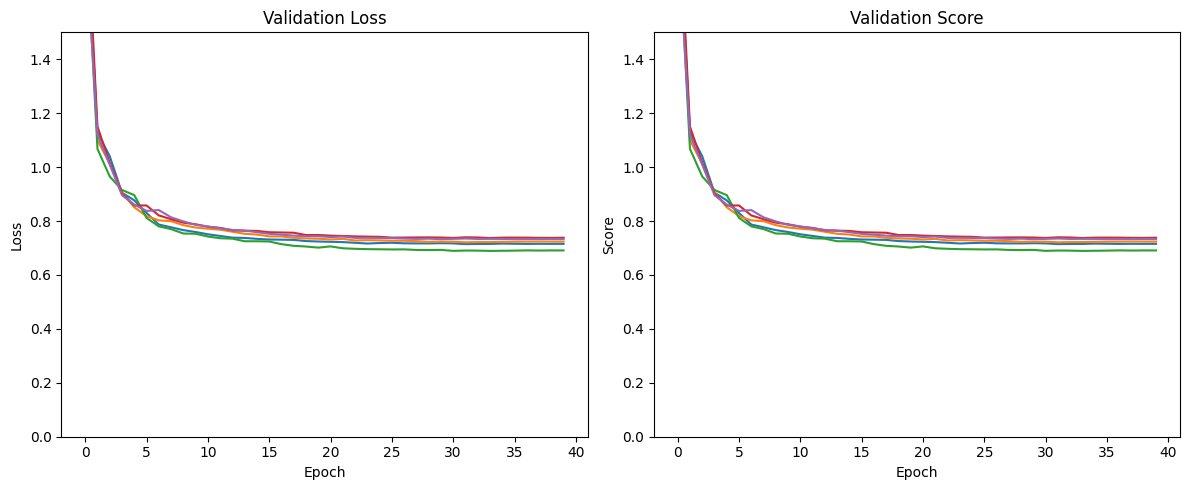

In [22]:
main()

# inference

In [23]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [24]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/workspace/atmacup18/.venv/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
/tmp/ipykernel_33553/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't

pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0_2/atmacup_18-models/tf_efficientnet_b0_ns_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0_2/atmacup_18-models/tf_efficientnet_b0_ns_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0_2/atmacup_18-models/tf_efficientnet_b0_ns_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]